In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 3
2023-07-25 21:03:45.301392


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.0437)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(4.3481)
penalty_target_min tensor(-12.3136) penalty_target_max tensor(4.4203)
train_loss:  -10.528594821929932
valid_loss:  -10.668520739746091
h_min_tilde -12.313553 ell_tilde -10.556580005493164 kappa_tilde 0.0007544274373382015


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.9073486328125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.787654161453247

 2 3.503922939300537

 3 3.4091408252716064

 4 3.3671014308929443

 5 3.2658395767211914

 6 3.3431026935577393

 7 3.3060286045074463

 8 3.253553628921509

 9 3.3510377407073975

 10 3.36669659614563

 11 3.3295364379882812

 12 3.418403387069702

 13 3.3582265377044678

 14 3.4597854614257812

 15 3.281010866165161

 16 3.2945637702941895

 17 3.338466167449951

 18 3.2926025390625

 19 3.410649299621582

 20 3.379941701889038

 21 3.2789454460144043

 22 3.294999122619629

 23 3.422865152359009

 24 3.2257308959960938

 25 3.370457887649536

 26 3.3291971683502197

 27 3.393603801727295

 28 3.2895326614379883

 29 3.376371383666992

 30 3.331136703491211

 31 3.3924319744110107

 32 3.3170793056488037

 33 3.3175911903381348

 34 3.347123622894287

 35 3.2719693183898926

 36 3.2668933868408203

 37 3.3854618072509766

 38 3.3514695167541504

 39 3.4154300689697266

 40 4.5504443645477295

 41 6.991392374038696

 42 6.695434093475342

 43 6.021219968795776


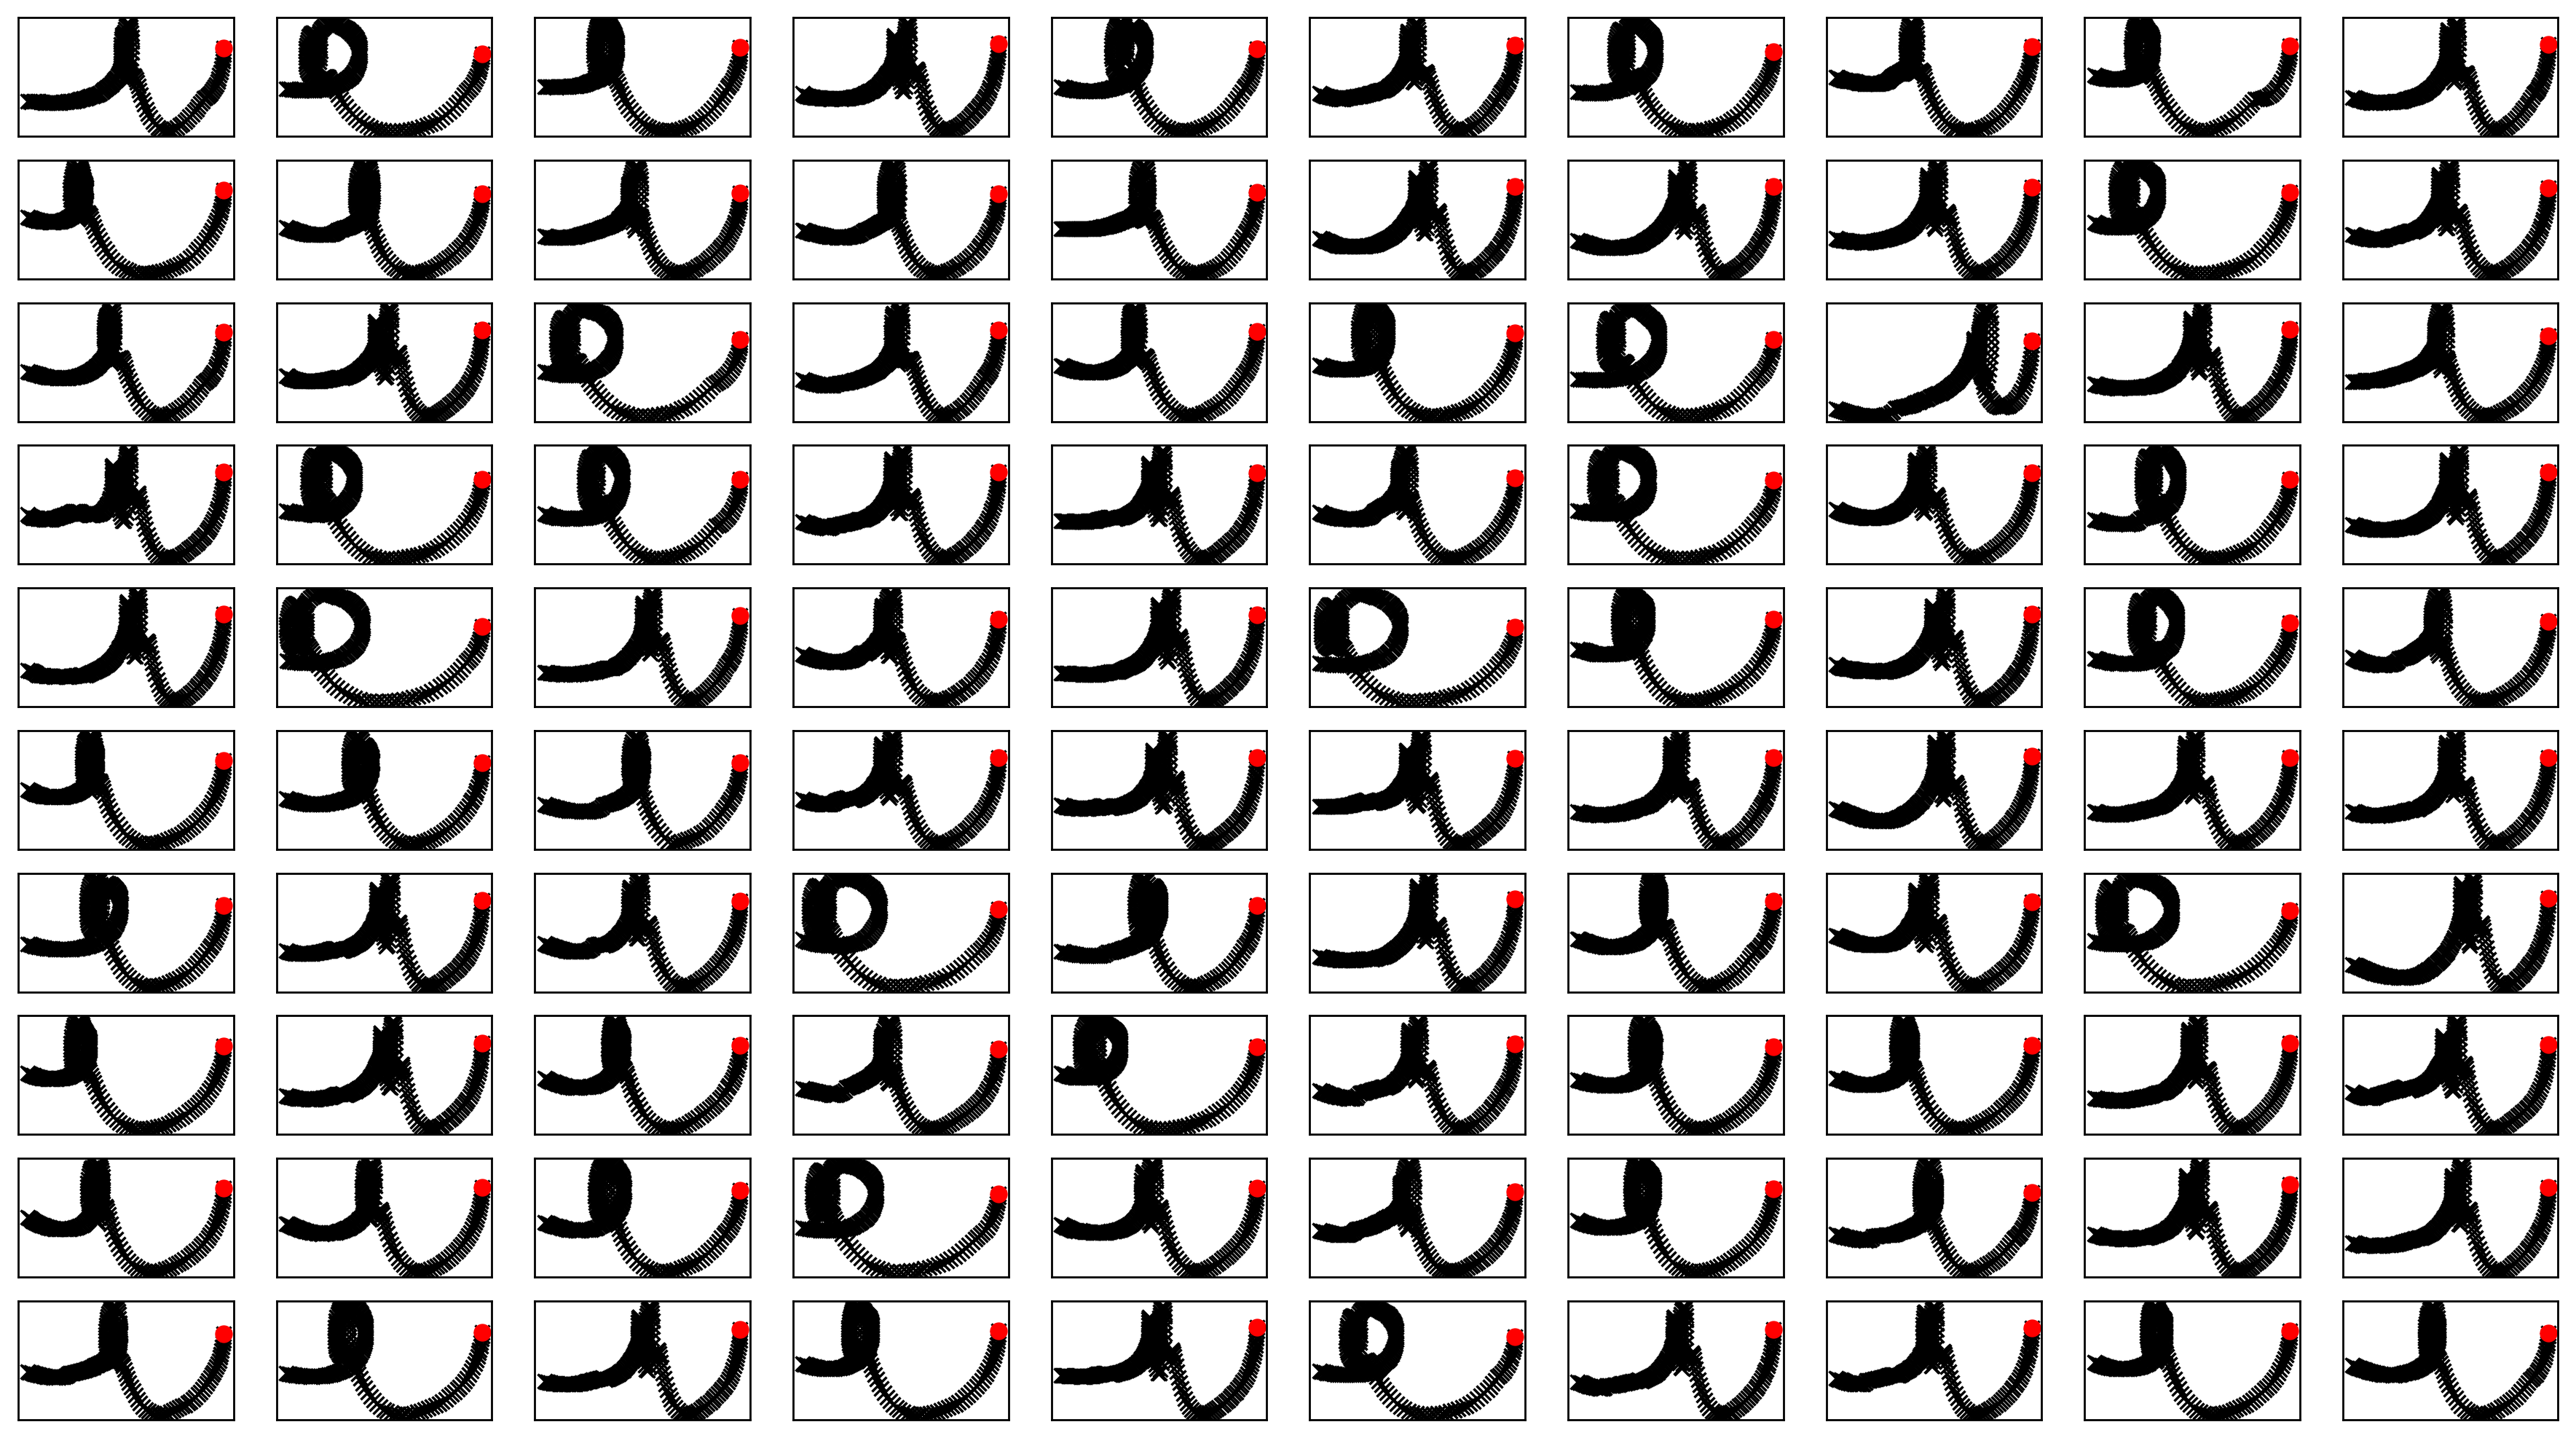

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

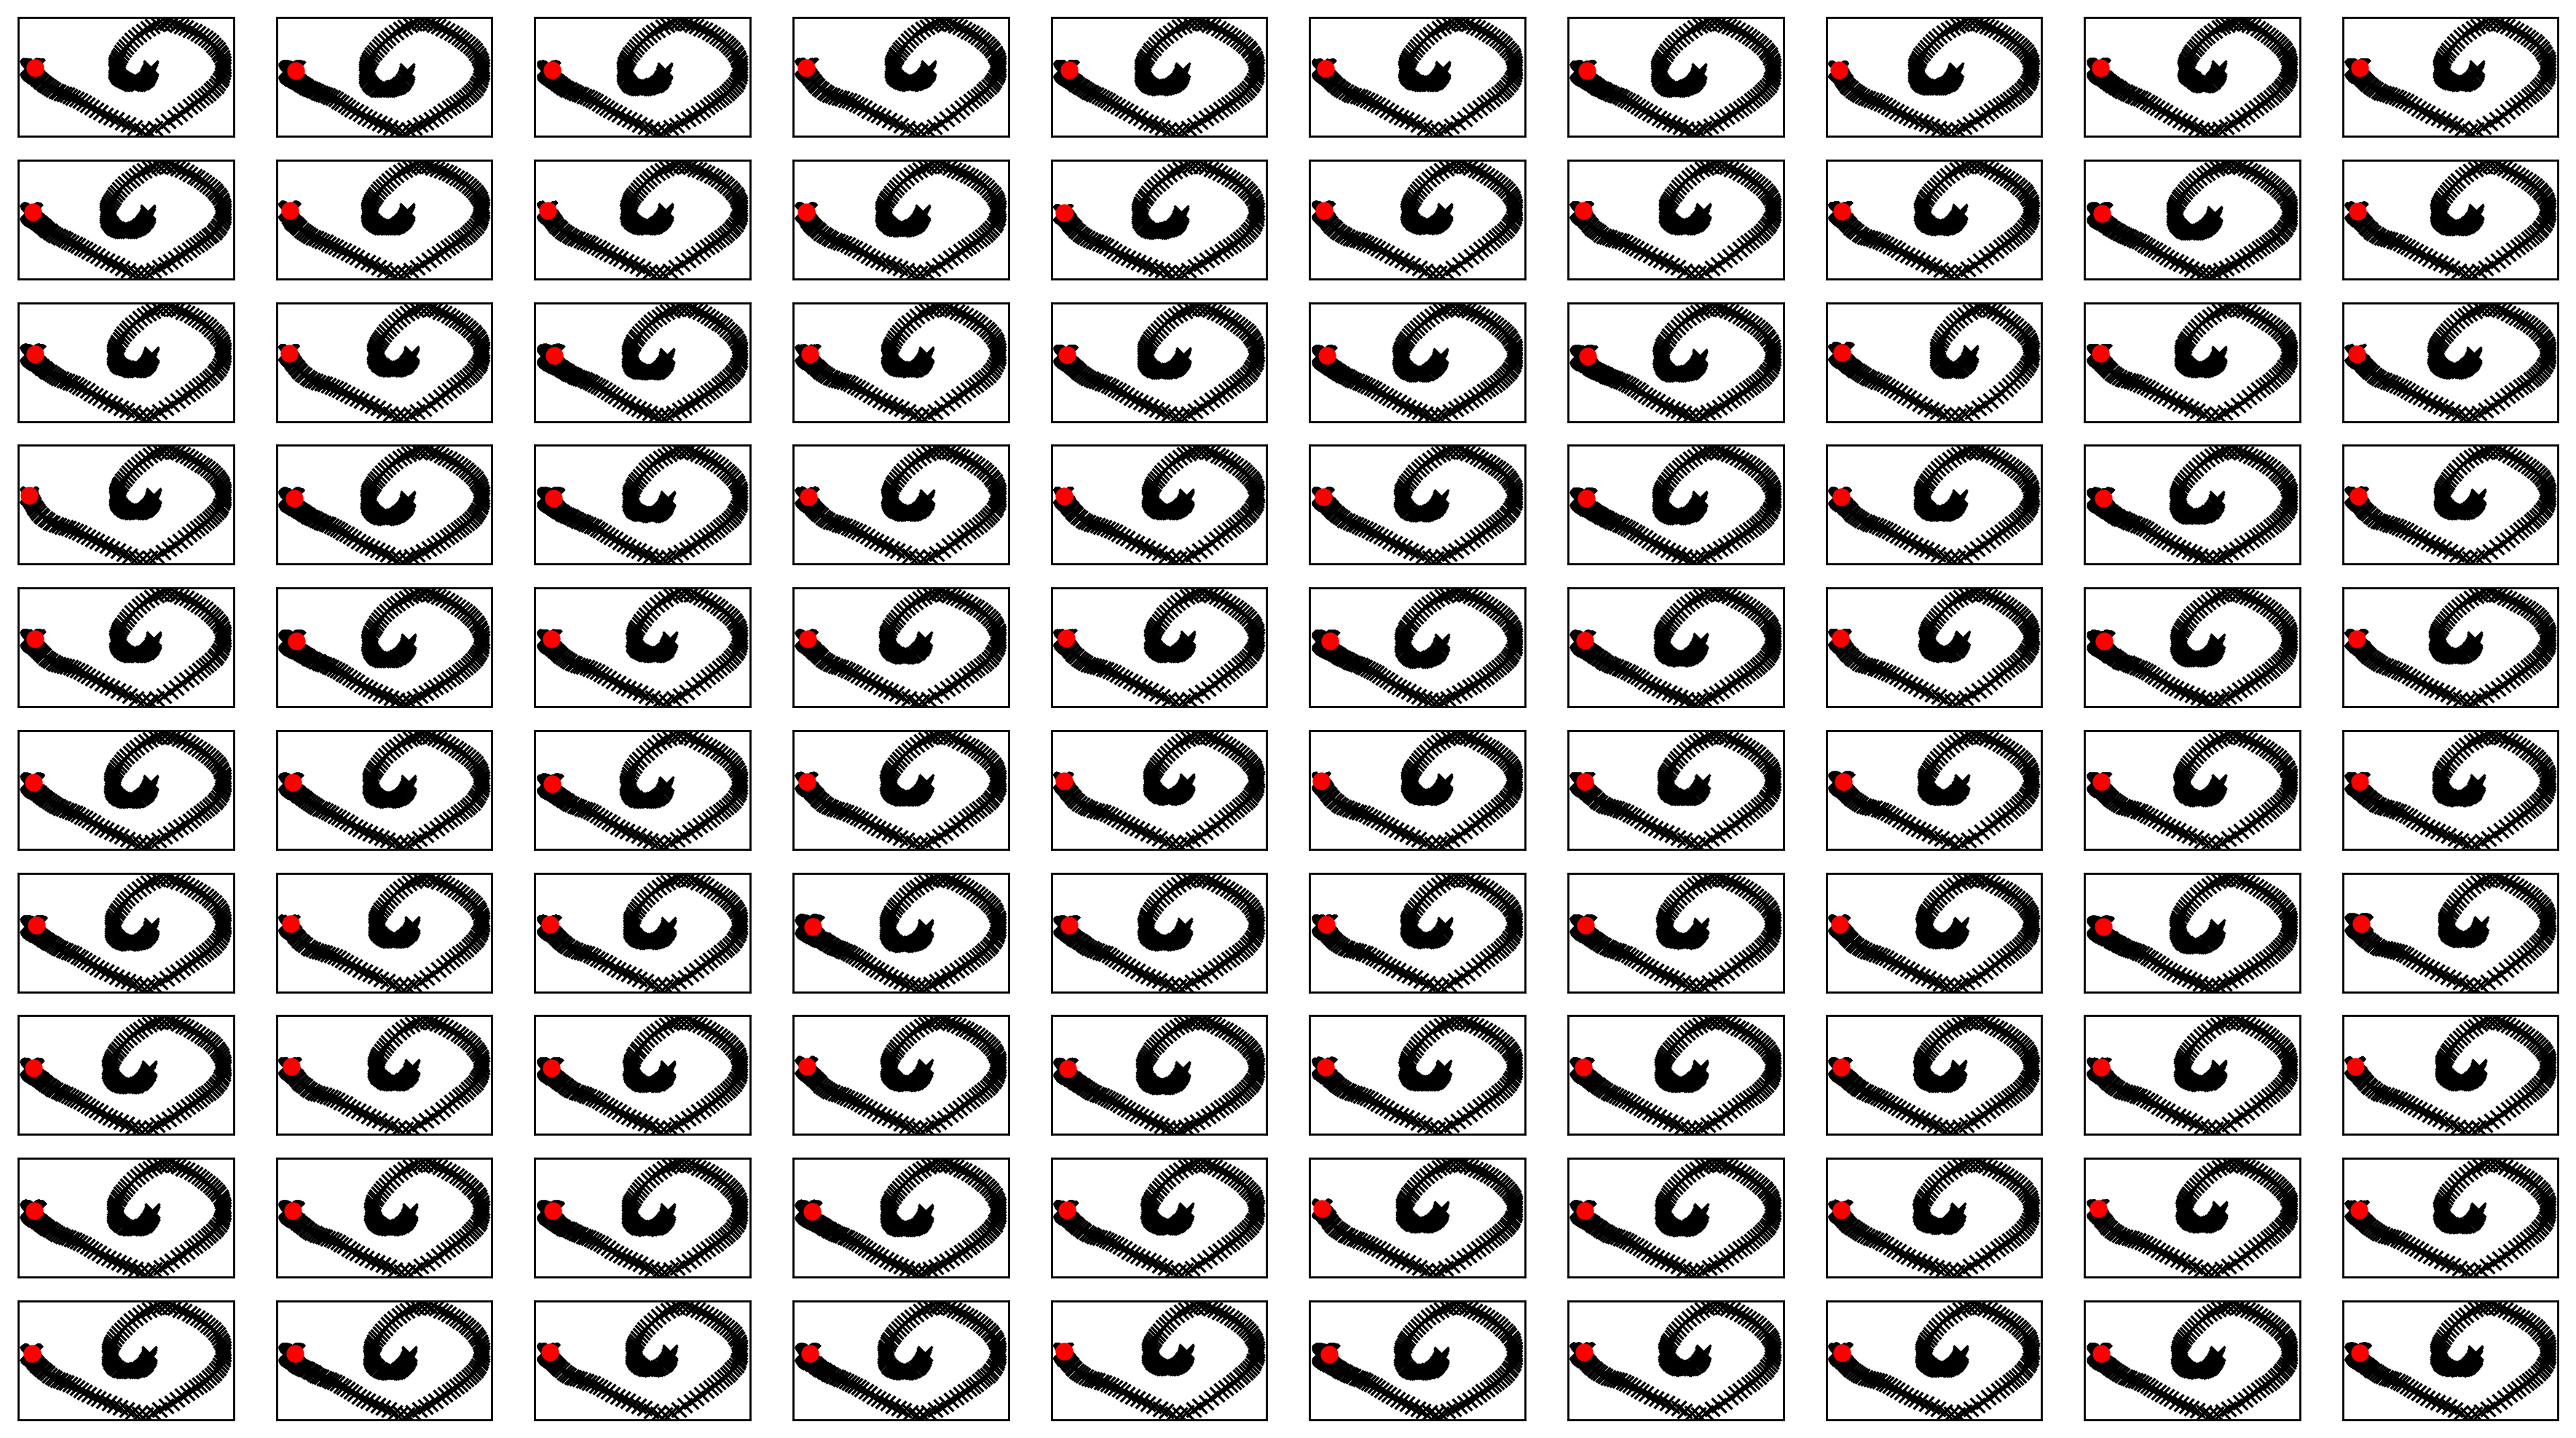

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-25 21:09:39.096091


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.38340  validloss 1.42189±0.00000  bestvalidloss 1.42189  last_update 0
train: iter 1  trainloss 1.33953  validloss 1.36282±0.00000  bestvalidloss 1.36282  last_update 0
train: iter 2  trainloss 1.30159  validloss 1.32068±0.00000  bestvalidloss 1.32068  last_update 0
train: iter 3  trainloss 1.27633  validloss 1.29265±0.00000  bestvalidloss 1.29265  last_update 0
train: iter 4  trainloss 1.25629  validloss 1.27934±0.00000  bestvalidloss 1.27934  last_update 0
train: iter 5  trainloss 1.24315  validloss 1.27486±0.00000  bestvalidloss 1.27486  last_update 0
train: iter 6  trainloss 1.22726  validloss 1.26158±0.00000  bestvalidloss 1.26158  last_update 0
train: iter 7  trainloss 1.20705  validloss 1.24377±0.00000  bestvalidloss 1.24377  last_update 0
train: iter 8  trainloss 1.18463  validloss 1.22518±0.00000  bestvalidloss 1.22518  last_update 0
train: iter 9  trainloss 1.15917  validloss 1.19815±0.00000  bestvalidloss 1.19815  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.77520  validloss 0.81735±0.00000  bestvalidloss 0.81735  last_update 0
train: iter 84  trainloss 0.78441  validloss 0.87616±0.00000  bestvalidloss 0.81735  last_update 1
train: iter 85  trainloss 0.76849  validloss 0.82675±0.00000  bestvalidloss 0.81735  last_update 2
train: iter 86  trainloss 0.77611  validloss 0.81883±0.00000  bestvalidloss 0.81735  last_update 3
train: iter 87  trainloss 0.77456  validloss 0.86101±0.00000  bestvalidloss 0.81735  last_update 4
train: iter 88  trainloss 0.76651  validloss 0.82855±0.00000  bestvalidloss 0.81735  last_update 5
train: iter 89  trainloss 0.76945  validloss 0.82997±0.00000  bestvalidloss 0.81735  last_update 6
train: iter 90  trainloss 0.76881  validloss 0.84909±0.00000  bestvalidloss 0.81735  last_update 7
train: iter 91  trainloss 0.76574  validloss 0.84276±0.00000  bestvalidloss 0.81735  last_update 8
train: iter 92  trainloss 0.76589  validloss 0.81302±0.00000  bestvalidloss 0.81302  last_update 0
train: ite

train: iter 166  trainloss 0.71056  validloss 0.80742±0.00000  bestvalidloss 0.78661  last_update 17
train: iter 167  trainloss 0.71091  validloss 0.78652±0.00000  bestvalidloss 0.78652  last_update 0
train: iter 168  trainloss 0.72285  validloss 0.81576±0.00000  bestvalidloss 0.78652  last_update 1
train: iter 169  trainloss 0.70790  validloss 0.79061±0.00000  bestvalidloss 0.78652  last_update 2
train: iter 170  trainloss 0.70709  validloss 0.82906±0.00000  bestvalidloss 0.78652  last_update 3
train: iter 171  trainloss 0.70998  validloss 0.77496±0.00000  bestvalidloss 0.77496  last_update 0
train: iter 172  trainloss 0.70872  validloss 0.82317±0.00000  bestvalidloss 0.77496  last_update 1
train: iter 173  trainloss 0.70557  validloss 0.78387±0.00000  bestvalidloss 0.77496  last_update 2
train: iter 174  trainloss 0.70442  validloss 0.77837±0.00000  bestvalidloss 0.77496  last_update 3
train: iter 175  trainloss 0.70774  validloss 0.78828±0.00000  bestvalidloss 0.77496  last_update 4

train: iter 249  trainloss 0.67456  validloss 0.76362±0.00000  bestvalidloss 0.73186  last_update 1
train: iter 250  trainloss 0.66654  validloss 0.73083±0.00000  bestvalidloss 0.73083  last_update 0
train: iter 251  trainloss 0.65022  validloss 0.73580±0.00000  bestvalidloss 0.73083  last_update 1
train: iter 252  trainloss 0.67629  validloss 0.79695±0.00000  bestvalidloss 0.73083  last_update 2
train: iter 253  trainloss 0.67134  validloss 0.75394±0.00000  bestvalidloss 0.73083  last_update 3
train: iter 254  trainloss 0.66375  validloss 0.75670±0.00000  bestvalidloss 0.73083  last_update 4
train: iter 255  trainloss 0.66352  validloss 0.79845±0.00000  bestvalidloss 0.73083  last_update 5
train: iter 256  trainloss 0.67678  validloss 0.75448±0.00000  bestvalidloss 0.73083  last_update 6
train: iter 257  trainloss 0.66282  validloss 0.73431±0.00000  bestvalidloss 0.73083  last_update 7
train: iter 258  trainloss 0.66755  validloss 0.75424±0.00000  bestvalidloss 0.73083  last_update 8


train: iter 332  trainloss 0.64600  validloss 0.74439±0.00000  bestvalidloss 0.70740  last_update 15
train: iter 333  trainloss 0.64130  validloss 0.72905±0.00000  bestvalidloss 0.70740  last_update 16
train: iter 334  trainloss 0.64318  validloss 0.71377±0.00000  bestvalidloss 0.70740  last_update 17
train: iter 335  trainloss 0.63719  validloss 0.72330±0.00000  bestvalidloss 0.70740  last_update 18
train: iter 336  trainloss 0.62832  validloss 0.72629±0.00000  bestvalidloss 0.70740  last_update 19
train: iter 337  trainloss 0.64948  validloss 0.72203±0.00000  bestvalidloss 0.70740  last_update 20
train: iter 338  trainloss 0.64350  validloss 0.79490±0.00000  bestvalidloss 0.70740  last_update 21
train: iter 339  trainloss 0.63277  validloss 0.70287±0.00000  bestvalidloss 0.70287  last_update 0
train: iter 340  trainloss 0.65684  validloss 0.73357±0.00000  bestvalidloss 0.70287  last_update 1
train: iter 341  trainloss 0.62837  validloss 0.70651±0.00000  bestvalidloss 0.70287  last_up

train: iter 414  trainloss 0.61579  validloss 0.73324±0.00000  bestvalidloss 0.68639  last_update 1
train: iter 415  trainloss 0.60610  validloss 0.69139±0.00000  bestvalidloss 0.68639  last_update 2
train: iter 416  trainloss 0.60561  validloss 0.74771±0.00000  bestvalidloss 0.68639  last_update 3
train: iter 417  trainloss 0.60192  validloss 0.70681±0.00000  bestvalidloss 0.68639  last_update 4
train: iter 418  trainloss 0.61353  validloss 0.69766±0.00000  bestvalidloss 0.68639  last_update 5
train: iter 419  trainloss 0.61152  validloss 0.68196±0.00000  bestvalidloss 0.68196  last_update 0
train: iter 420  trainloss 0.61234  validloss 0.70650±0.00000  bestvalidloss 0.68196  last_update 1
train: iter 421  trainloss 0.61839  validloss 0.75991±0.00000  bestvalidloss 0.68196  last_update 2
train: iter 422  trainloss 0.61604  validloss 0.69563±0.00000  bestvalidloss 0.68196  last_update 3
train: iter 423  trainloss 0.60573  validloss 0.69009±0.00000  bestvalidloss 0.68196  last_update 4


train: iter 496  trainloss 0.59202  validloss 0.67710±0.00000  bestvalidloss 0.66134  last_update 1
train: iter 497  trainloss 0.58083  validloss 0.66641±0.00000  bestvalidloss 0.66134  last_update 2
train: iter 498  trainloss 0.58411  validloss 0.68688±0.00000  bestvalidloss 0.66134  last_update 3
train: iter 499  trainloss 0.57709  validloss 0.68711±0.00000  bestvalidloss 0.66134  last_update 4
train: iter 500  trainloss 0.58000  validloss 0.67002±0.00000  bestvalidloss 0.66134  last_update 5
train: iter 501  trainloss 0.58034  validloss 0.67533±0.00000  bestvalidloss 0.66134  last_update 6
train: iter 502  trainloss 0.58096  validloss 0.67336±0.00000  bestvalidloss 0.66134  last_update 7
train: iter 503  trainloss 0.59420  validloss 0.67588±0.00000  bestvalidloss 0.66134  last_update 8
train: iter 504  trainloss 0.57979  validloss 0.68161±0.00000  bestvalidloss 0.66134  last_update 9
train: iter 505  trainloss 0.58051  validloss 0.66904±0.00000  bestvalidloss 0.66134  last_update 10

train: iter 578  trainloss 0.56022  validloss 0.66242±0.00000  bestvalidloss 0.65382  last_update 32
train: iter 579  trainloss 0.56220  validloss 0.65223±0.00000  bestvalidloss 0.65223  last_update 0
train: iter 580  trainloss 0.55384  validloss 0.65484±0.00000  bestvalidloss 0.65223  last_update 1
train: iter 581  trainloss 0.56106  validloss 0.65313±0.00000  bestvalidloss 0.65223  last_update 2
train: iter 582  trainloss 0.57842  validloss 0.69225±0.00000  bestvalidloss 0.65223  last_update 3
train: iter 583  trainloss 0.56570  validloss 0.65029±0.00000  bestvalidloss 0.65029  last_update 0
train: iter 584  trainloss 0.56035  validloss 0.65959±0.00000  bestvalidloss 0.65029  last_update 1
train: iter 585  trainloss 0.55572  validloss 0.67631±0.00000  bestvalidloss 0.65029  last_update 2
train: iter 586  trainloss 0.55707  validloss 0.65392±0.00000  bestvalidloss 0.65029  last_update 3
train: iter 587  trainloss 0.55159  validloss 0.65168±0.00000  bestvalidloss 0.65029  last_update 4

train: iter 660  trainloss 0.54884  validloss 0.64156±0.00000  bestvalidloss 0.63885  last_update 5
train: iter 661  trainloss 0.54178  validloss 0.65756±0.00000  bestvalidloss 0.63885  last_update 6
train: iter 662  trainloss 0.53891  validloss 0.63986±0.00000  bestvalidloss 0.63885  last_update 7
train: iter 663  trainloss 0.54166  validloss 0.64635±0.00000  bestvalidloss 0.63885  last_update 8
train: iter 664  trainloss 0.54333  validloss 0.74158±0.00000  bestvalidloss 0.63885  last_update 9
train: iter 665  trainloss 0.53930  validloss 0.65358±0.00000  bestvalidloss 0.63885  last_update 10
train: iter 666  trainloss 0.54518  validloss 0.64120±0.00000  bestvalidloss 0.63885  last_update 11
train: iter 667  trainloss 0.54861  validloss 0.69161±0.00000  bestvalidloss 0.63885  last_update 12
train: iter 668  trainloss 0.53683  validloss 0.65946±0.00000  bestvalidloss 0.63885  last_update 13
train: iter 669  trainloss 0.54332  validloss 0.66131±0.00000  bestvalidloss 0.63885  last_updat

train: iter 742  trainloss 0.53384  validloss 0.67581±0.00000  bestvalidloss 0.62779  last_update 16
train: iter 743  trainloss 0.52998  validloss 0.63284±0.00000  bestvalidloss 0.62779  last_update 17
train: iter 744  trainloss 0.52173  validloss 0.65371±0.00000  bestvalidloss 0.62779  last_update 18
train: iter 745  trainloss 0.54391  validloss 0.64868±0.00000  bestvalidloss 0.62779  last_update 19
train: iter 746  trainloss 0.52018  validloss 0.65794±0.00000  bestvalidloss 0.62779  last_update 20
train: iter 747  trainloss 0.52375  validloss 0.65360±0.00000  bestvalidloss 0.62779  last_update 21
train: iter 748  trainloss 0.53307  validloss 0.63581±0.00000  bestvalidloss 0.62779  last_update 22
train: iter 749  trainloss 0.52409  validloss 0.66044±0.00000  bestvalidloss 0.62779  last_update 23
train: iter 750  trainloss 0.52407  validloss 0.63033±0.00000  bestvalidloss 0.62779  last_update 24
train: iter 751  trainloss 0.52343  validloss 0.64368±0.00000  bestvalidloss 0.62779  last_

train: iter 824  trainloss 0.50767  validloss 0.62946±0.00000  bestvalidloss 0.62554  last_update 7
train: iter 825  trainloss 0.51651  validloss 0.64230±0.00000  bestvalidloss 0.62554  last_update 8
train: iter 826  trainloss 0.50976  validloss 0.63362±0.00000  bestvalidloss 0.62554  last_update 9
train: iter 827  trainloss 0.51114  validloss 0.65259±0.00000  bestvalidloss 0.62554  last_update 10
train: iter 828  trainloss 0.51205  validloss 0.65900±0.00000  bestvalidloss 0.62554  last_update 11
train: iter 829  trainloss 0.51055  validloss 0.62923±0.00000  bestvalidloss 0.62554  last_update 12
train: iter 830  trainloss 0.50282  validloss 0.66317±0.00000  bestvalidloss 0.62554  last_update 13
train: iter 831  trainloss 0.49986  validloss 0.64245±0.00000  bestvalidloss 0.62554  last_update 14
train: iter 832  trainloss 0.51070  validloss 0.66433±0.00000  bestvalidloss 0.62554  last_update 15
train: iter 833  trainloss 0.51125  validloss 0.70448±0.00000  bestvalidloss 0.62554  last_upd

train: iter 906  trainloss 0.49285  validloss 0.63937±0.00000  bestvalidloss 0.61781  last_update 51
train: iter 907  trainloss 0.48893  validloss 0.63910±0.00000  bestvalidloss 0.61781  last_update 52
train: iter 908  trainloss 0.50376  validloss 0.63266±0.00000  bestvalidloss 0.61781  last_update 53
train: iter 909  trainloss 0.48677  validloss 0.64164±0.00000  bestvalidloss 0.61781  last_update 54
train: iter 910  trainloss 0.49227  validloss 0.62616±0.00000  bestvalidloss 0.61781  last_update 55
train: iter 911  trainloss 0.49015  validloss 0.62370±0.00000  bestvalidloss 0.61781  last_update 56
train: iter 912  trainloss 0.48676  validloss 0.62845±0.00000  bestvalidloss 0.61781  last_update 57
train: iter 913  trainloss 0.49697  validloss 0.62633±0.00000  bestvalidloss 0.61781  last_update 58
train: iter 914  trainloss 0.48785  validloss 0.62513±0.00000  bestvalidloss 0.61781  last_update 59
train: iter 915  trainloss 0.49185  validloss 0.66185±0.00000  bestvalidloss 0.61781  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.452913223478198
valid_loss:  -8.856432767868041
weight_alpha 1.0 h_min_tilde -12.313553 ell_tilde -6.933617132356167 kappa_tilde 0.00043113318898312965
train_loss:  -5.2514714493751535
valid_loss:  -5.907020597839355
weight_alpha 0.2 h_min_tilde -12.313553 ell_tilde -5.382581279067994 kappa_tilde 0.0003798419624467276


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1015.05844  validloss -1175.54565±0.00000  bestvalidloss -1175.54565  last_update 0
train: iter 1  trainloss -1024.20064  validloss -1147.58780±0.00000  bestvalidloss -1175.54565  last_update 1
train: iter 2  trainloss -1041.58561  validloss -1208.50751±0.00000  bestvalidloss -1208.50751  last_update 0
train: iter 3  trainloss -1027.83046  validloss -1136.25428±0.00000  bestvalidloss -1208.50751  last_update 1
train: iter 4  trainloss -1000.87865  validloss -1174.07016±0.00000  bestvalidloss -1208.50751  last_update 2
train: iter 5  trainloss -1025.87953  validloss -1109.55973±0.00000  bestvalidloss -1208.50751  last_update 3
train: iter 6  trainloss -1033.95578  validloss -1174.40781±0.00000  bestvalidloss -1208.50751  last_update 4
train: iter 7  trainloss -1052.30639  validloss -1174.58547±0.00000  bestvalidloss -1208.50751  last_update 5
train: iter 8  trainloss -1047.19617  validloss -1135.69842±0.00000  bestva

train: iter 74  trainloss -1140.94201  validloss -1306.01285±0.00000  bestvalidloss -1322.10960  last_update 4
train: iter 75  trainloss -1150.73392  validloss -1335.11786±0.00000  bestvalidloss -1335.11786  last_update 0
train: iter 76  trainloss -1132.98626  validloss -1334.51378±0.00000  bestvalidloss -1335.11786  last_update 1
train: iter 77  trainloss -1145.78728  validloss -1245.55489±0.00000  bestvalidloss -1335.11786  last_update 2
train: iter 78  trainloss -1145.85234  validloss -1239.80858±0.00000  bestvalidloss -1335.11786  last_update 3
train: iter 79  trainloss -1175.45831  validloss -1297.14914±0.00000  bestvalidloss -1335.11786  last_update 4
train: iter 80  trainloss -1166.10418  validloss -1239.64346±0.00000  bestvalidloss -1335.11786  last_update 5
train: iter 81  trainloss -1136.03511  validloss -1271.37768±0.00000  bestvalidloss -1335.11786  last_update 6
train: iter 82  trainloss -1161.46385  validloss -1291.62946±0.00000  bestvalidloss -1335.11786  last_update 7
t

train: iter 148  trainloss -1263.73201  validloss -1362.63759±0.00000  bestvalidloss -1429.66760  last_update 30
train: iter 149  trainloss -1271.77378  validloss -1419.22776±0.00000  bestvalidloss -1429.66760  last_update 31
train: iter 150  trainloss -1257.30581  validloss -1451.38368±0.00000  bestvalidloss -1451.38368  last_update 0
train: iter 151  trainloss -1251.28260  validloss -1400.35190±0.00000  bestvalidloss -1451.38368  last_update 1
train: iter 152  trainloss -1261.09200  validloss -1412.81584±0.00000  bestvalidloss -1451.38368  last_update 2
train: iter 153  trainloss -1230.10281  validloss -1366.40278±0.00000  bestvalidloss -1451.38368  last_update 3
train: iter 154  trainloss -1296.32193  validloss -1439.08133±0.00000  bestvalidloss -1451.38368  last_update 4
train: iter 155  trainloss -1284.22930  validloss -1453.71987±0.00000  bestvalidloss -1453.71987  last_update 0
train: iter 156  trainloss -1288.92632  validloss -1404.81335±0.00000  bestvalidloss -1453.71987  last

train: iter 221  trainloss -1361.30371  validloss -1463.35901±0.00000  bestvalidloss -1545.46065  last_update 16
train: iter 222  trainloss -1376.69285  validloss -1486.66311±0.00000  bestvalidloss -1545.46065  last_update 17
train: iter 223  trainloss -1363.94782  validloss -1478.13738±0.00000  bestvalidloss -1545.46065  last_update 18
train: iter 224  trainloss -1368.84467  validloss -1525.89835±0.00000  bestvalidloss -1545.46065  last_update 19
train: iter 225  trainloss -1380.61149  validloss -1516.77342±0.00000  bestvalidloss -1545.46065  last_update 20
train: iter 226  trainloss -1378.54580  validloss -1475.36052±0.00000  bestvalidloss -1545.46065  last_update 21
train: iter 227  trainloss -1357.15149  validloss -1534.88046±0.00000  bestvalidloss -1545.46065  last_update 22
train: iter 228  trainloss -1359.38691  validloss -1521.67570±0.00000  bestvalidloss -1545.46065  last_update 23
train: iter 229  trainloss -1369.47822  validloss -1489.64721±0.00000  bestvalidloss -1545.46065

train: iter 294  trainloss -1502.76113  validloss -1534.98950±0.00000  bestvalidloss -1752.14831  last_update 21
train: iter 295  trainloss -1502.82893  validloss -1586.31186±0.00000  bestvalidloss -1752.14831  last_update 22
train: iter 296  trainloss -1504.11219  validloss -1686.84751±0.00000  bestvalidloss -1752.14831  last_update 23
train: iter 297  trainloss -1500.22260  validloss -1613.37388±0.00000  bestvalidloss -1752.14831  last_update 24
train: iter 298  trainloss -1494.07271  validloss -1691.94180±0.00000  bestvalidloss -1752.14831  last_update 25
train: iter 299  trainloss -1473.63877  validloss -1626.84531±0.00000  bestvalidloss -1752.14831  last_update 26
train: iter 300  trainloss -1477.71035  validloss -1605.26276±0.00000  bestvalidloss -1752.14831  last_update 27
train: iter 301  trainloss -1481.09736  validloss -1603.32354±0.00000  bestvalidloss -1752.14831  last_update 28
train: iter 302  trainloss -1480.30168  validloss -1626.78894±0.00000  bestvalidloss -1752.14831

train: iter 367  trainloss -1610.18802  validloss -1822.70617±0.00000  bestvalidloss -1954.35219  last_update 6
train: iter 368  trainloss -1574.00795  validloss -1820.89663±0.00000  bestvalidloss -1954.35219  last_update 7
train: iter 369  trainloss -1630.45431  validloss -1791.31496±0.00000  bestvalidloss -1954.35219  last_update 8
train: iter 370  trainloss -1630.79011  validloss -1831.32083±0.00000  bestvalidloss -1954.35219  last_update 9
train: iter 371  trainloss -1642.66015  validloss -1847.15947±0.00000  bestvalidloss -1954.35219  last_update 10
train: iter 372  trainloss -1632.71365  validloss -1751.93632±0.00000  bestvalidloss -1954.35219  last_update 11
train: iter 373  trainloss -1649.67907  validloss -1830.69703±0.00000  bestvalidloss -1954.35219  last_update 12
train: iter 374  trainloss -1636.30575  validloss -1915.64994±0.00000  bestvalidloss -1954.35219  last_update 13
train: iter 375  trainloss -1625.95039  validloss -1690.73951±0.00000  bestvalidloss -1954.35219  la

train: iter 440  trainloss -1765.36357  validloss -2027.66880±0.00000  bestvalidloss -2085.79476  last_update 3
train: iter 441  trainloss -1779.89219  validloss -2003.76024±0.00000  bestvalidloss -2085.79476  last_update 4
train: iter 442  trainloss -1753.67082  validloss -2025.89524±0.00000  bestvalidloss -2085.79476  last_update 5
train: iter 443  trainloss -1792.61814  validloss -1967.92168±0.00000  bestvalidloss -2085.79476  last_update 6
train: iter 444  trainloss -1773.21704  validloss -1895.74786±0.00000  bestvalidloss -2085.79476  last_update 7
train: iter 445  trainloss -1785.74257  validloss -2037.35736±0.00000  bestvalidloss -2085.79476  last_update 8
train: iter 446  trainloss -1787.93357  validloss -2087.63654±0.00000  bestvalidloss -2087.63654  last_update 0
train: iter 447  trainloss -1787.07565  validloss -1981.85569±0.00000  bestvalidloss -2087.63654  last_update 1
train: iter 448  trainloss -1733.13734  validloss -1937.82259±0.00000  bestvalidloss -2087.63654  last_u

train: iter 513  trainloss -1882.81537  validloss -2218.99050±0.00000  bestvalidloss -2219.89872  last_update 3
train: iter 514  trainloss -1875.35556  validloss -2040.46878±0.00000  bestvalidloss -2219.89872  last_update 4
train: iter 515  trainloss -1890.77020  validloss -2196.26288±0.00000  bestvalidloss -2219.89872  last_update 5
train: iter 516  trainloss -1899.80064  validloss -2136.13912±0.00000  bestvalidloss -2219.89872  last_update 6
train: iter 517  trainloss -1876.31425  validloss -2055.09320±0.00000  bestvalidloss -2219.89872  last_update 7
train: iter 518  trainloss -1912.31491  validloss -2165.30566±0.00000  bestvalidloss -2219.89872  last_update 8
train: iter 519  trainloss -1876.53644  validloss -2175.02501±0.00000  bestvalidloss -2219.89872  last_update 9
train: iter 520  trainloss -1923.60468  validloss -2179.26260±0.00000  bestvalidloss -2219.89872  last_update 10
train: iter 521  trainloss -1876.47266  validloss -2077.70519±0.00000  bestvalidloss -2219.89872  last_

train: iter 587  trainloss -2007.96766  validloss -2281.29978±0.00000  bestvalidloss -2320.71635  last_update 16
train: iter 588  trainloss -2017.76791  validloss -2181.92856±0.00000  bestvalidloss -2320.71635  last_update 17
train: iter 589  trainloss -1959.55173  validloss -2210.24762±0.00000  bestvalidloss -2320.71635  last_update 18
train: iter 590  trainloss -2017.26001  validloss -2348.83723±0.00000  bestvalidloss -2348.83723  last_update 0
train: iter 591  trainloss -1920.86546  validloss -2222.60972±0.00000  bestvalidloss -2348.83723  last_update 1
train: iter 592  trainloss -1966.49703  validloss -2222.42465±0.00000  bestvalidloss -2348.83723  last_update 2
train: iter 593  trainloss -2017.73391  validloss -2256.92059±0.00000  bestvalidloss -2348.83723  last_update 3
train: iter 594  trainloss -2009.58234  validloss -2169.88676±0.00000  bestvalidloss -2348.83723  last_update 4
train: iter 595  trainloss -1994.10474  validloss -2325.58413±0.00000  bestvalidloss -2348.83723  las

train: iter 660  trainloss -2096.63581  validloss -2434.41767±0.00000  bestvalidloss -2434.41767  last_update 0
train: iter 661  trainloss -2071.64735  validloss -2369.26724±0.00000  bestvalidloss -2434.41767  last_update 1
train: iter 662  trainloss -2106.33947  validloss -2436.05945±0.00000  bestvalidloss -2436.05945  last_update 0
train: iter 663  trainloss -2094.21209  validloss -2440.52830±0.00000  bestvalidloss -2440.52830  last_update 0
train: iter 664  trainloss -2110.71259  validloss -2381.25404±0.00000  bestvalidloss -2440.52830  last_update 1
train: iter 665  trainloss -2116.79306  validloss -2456.46409±0.00000  bestvalidloss -2456.46409  last_update 0
train: iter 666  trainloss -2103.61611  validloss -2285.77510±0.00000  bestvalidloss -2456.46409  last_update 1
train: iter 667  trainloss -2065.20365  validloss -2410.93752±0.00000  bestvalidloss -2456.46409  last_update 2
train: iter 668  trainloss -2104.71575  validloss -2416.57102±0.00000  bestvalidloss -2456.46409  last_u

train: iter 733  trainloss -2159.02143  validloss -2411.22067±0.00000  bestvalidloss -2586.37653  last_update 6
train: iter 734  trainloss -2181.77640  validloss -2462.79280±0.00000  bestvalidloss -2586.37653  last_update 7
train: iter 735  trainloss -2195.80276  validloss -2447.81708±0.00000  bestvalidloss -2586.37653  last_update 8
train: iter 736  trainloss -2173.52131  validloss -2494.16057±0.00000  bestvalidloss -2586.37653  last_update 9
train: iter 737  trainloss -2178.29929  validloss -2470.08641±0.00000  bestvalidloss -2586.37653  last_update 10
train: iter 738  trainloss -2213.99681  validloss -2440.22177±0.00000  bestvalidloss -2586.37653  last_update 11
train: iter 739  trainloss -2214.79735  validloss -2467.03136±0.00000  bestvalidloss -2586.37653  last_update 12
train: iter 740  trainloss -2206.38491  validloss -2550.65322±0.00000  bestvalidloss -2586.37653  last_update 13
train: iter 741  trainloss -2160.99634  validloss -2383.79427±0.00000  bestvalidloss -2586.37653  la

train: iter 806  trainloss -2223.90450  validloss -2542.73515±0.00000  bestvalidloss -2638.86895  last_update 19
train: iter 807  trainloss -2238.45354  validloss -2513.37862±0.00000  bestvalidloss -2638.86895  last_update 20
train: iter 808  trainloss -2244.74990  validloss -2623.52950±0.00000  bestvalidloss -2638.86895  last_update 21
train: iter 809  trainloss -2245.61016  validloss -2576.96218±0.00000  bestvalidloss -2638.86895  last_update 22
train: iter 810  trainloss -2226.14286  validloss -2612.35043±0.00000  bestvalidloss -2638.86895  last_update 23
train: iter 811  trainloss -2241.99360  validloss -2545.03654±0.00000  bestvalidloss -2638.86895  last_update 24
train: iter 812  trainloss -2221.38207  validloss -2629.20142±0.00000  bestvalidloss -2638.86895  last_update 25
train: iter 813  trainloss -2278.79804  validloss -2552.82721±0.00000  bestvalidloss -2638.86895  last_update 26
train: iter 814  trainloss -2256.58320  validloss -2599.35602±0.00000  bestvalidloss -2638.86895

train: iter 879  trainloss -2293.60489  validloss -2630.10532±0.00000  bestvalidloss -2712.92719  last_update 9
train: iter 880  trainloss -2294.48566  validloss -2660.32827±0.00000  bestvalidloss -2712.92719  last_update 10
train: iter 881  trainloss -2304.96250  validloss -2741.46662±0.00000  bestvalidloss -2741.46662  last_update 0
train: iter 882  trainloss -2291.48896  validloss -2571.96439±0.00000  bestvalidloss -2741.46662  last_update 1
train: iter 883  trainloss -2244.27899  validloss -2625.90533±0.00000  bestvalidloss -2741.46662  last_update 2
train: iter 884  trainloss -2272.34013  validloss -2672.89719±0.00000  bestvalidloss -2741.46662  last_update 3
train: iter 885  trainloss -2286.48550  validloss -2634.28700±0.00000  bestvalidloss -2741.46662  last_update 4
train: iter 886  trainloss -2296.34795  validloss -2680.44197±0.00000  bestvalidloss -2741.46662  last_update 5
train: iter 887  trainloss -2303.71115  validloss -2561.39424±0.00000  bestvalidloss -2741.46662  last_

train: iter 952  trainloss -2283.23504  validloss -2586.71497±0.00000  bestvalidloss -2780.58164  last_update 6
train: iter 953  trainloss -2320.90822  validloss -2720.09751±0.00000  bestvalidloss -2780.58164  last_update 7
train: iter 954  trainloss -2338.05298  validloss -2670.16017±0.00000  bestvalidloss -2780.58164  last_update 8
train: iter 955  trainloss -2327.30903  validloss -2652.67787±0.00000  bestvalidloss -2780.58164  last_update 9
train: iter 956  trainloss -2284.35783  validloss -2708.76591±0.00000  bestvalidloss -2780.58164  last_update 10
train: iter 957  trainloss -2299.41978  validloss -2696.33168±0.00000  bestvalidloss -2780.58164  last_update 11
train: iter 958  trainloss -2297.56494  validloss -2536.57073±0.00000  bestvalidloss -2780.58164  last_update 12
train: iter 959  trainloss -2326.01675  validloss -2601.28934±0.00000  bestvalidloss -2780.58164  last_update 13
train: iter 960  trainloss -2314.67708  validloss -2715.92192±0.00000  bestvalidloss -2780.58164  la

train: iter 1025  trainloss -2328.16507  validloss -2607.47774±0.00000  bestvalidloss -2780.58164  last_update 79
train: iter 1026  trainloss -2347.07924  validloss -2626.02226±0.00000  bestvalidloss -2780.58164  last_update 80
train: iter 1027  trainloss -2336.61864  validloss -2695.84502±0.00000  bestvalidloss -2780.58164  last_update 81
train: iter 1028  trainloss -2370.03091  validloss -2755.37877±0.00000  bestvalidloss -2780.58164  last_update 82
train: iter 1029  trainloss -2339.47814  validloss -2708.50908±0.00000  bestvalidloss -2780.58164  last_update 83
train: iter 1030  trainloss -2343.25219  validloss -2749.88881±0.00000  bestvalidloss -2780.58164  last_update 84
train: iter 1031  trainloss -2350.87330  validloss -2661.31335±0.00000  bestvalidloss -2780.58164  last_update 85
train: iter 1032  trainloss -2342.23231  validloss -2654.39101±0.00000  bestvalidloss -2780.58164  last_update 86
train: iter 1033  trainloss -2365.52483  validloss -2729.65865±0.00000  bestvalidloss -2

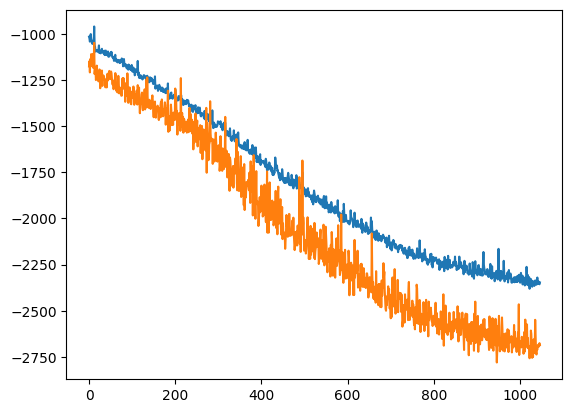

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-25 21:39:33.396861


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11
predict diverge [ -0.84173359  -2.28696837 -18.01984353 -24.89579273] [-0.03271075 -0.76947801 -0.46449917 -1.51140975] [17.218779  8.220233 54.91965  24.885656] [ 8.609389   4.1101165 27.459826  12.442828 ] sim_timestep 79

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.40621  validloss 2.07817±0.00000  bestvalidloss 2.07817  last_update 0
train: iter 1  trainloss 1.16095  validloss 1.39266±0.00000  bestvalidloss 1.39266  last_update 0
train: iter 2  trainloss 1.07097  validloss 1.25301±0.00000  bestvalidloss 1.25301  last_update 0
train: iter 3  trainloss 1.02206  validloss 1.17807±0.00000  bestvalidloss 1.17807  last_update 0
train: iter 4  trainloss 0.99474  validloss 1.10906±0.00000  bestvalidloss 1.10906  last_update 0
train: iter 5  trainloss 0.97066  validloss 1.08307±0.00000  bestvalidloss 1.08307  last_update 0
train: iter 6  trainloss 0.94271  validloss 1.03707±0.00000  bestvalidloss 1.03707  last_update 0
train: iter 7  trainloss 0.92387  validloss 1.04058±0.00000  bestvalidloss 1.03707  last_update 1
train: iter 8  trainloss 0.91439  validloss 1.01681±0.00000  bestvalidloss 1.01681  last_update 0
train: iter 9  trainloss 0.89222  validloss 1.03107±0.00000  bestvalidloss 1.01681  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.69694  validloss 0.81505±0.00000  bestvalidloss 0.79514  last_update 7
train: iter 84  trainloss 0.68503  validloss 0.83035±0.00000  bestvalidloss 0.79514  last_update 8
train: iter 85  trainloss 0.68541  validloss 0.79173±0.00000  bestvalidloss 0.79173  last_update 0
train: iter 86  trainloss 0.68293  validloss 0.82572±0.00000  bestvalidloss 0.79173  last_update 1
train: iter 87  trainloss 0.68852  validloss 0.79954±0.00000  bestvalidloss 0.79173  last_update 2
train: iter 88  trainloss 0.68297  validloss 0.80603±0.00000  bestvalidloss 0.79173  last_update 3
train: iter 89  trainloss 0.68555  validloss 0.87241±0.00000  bestvalidloss 0.79173  last_update 4
train: iter 90  trainloss 0.67602  validloss 0.78436±0.00000  bestvalidloss 0.78436  last_update 0
train: iter 91  trainloss 0.68244  validloss 0.78868±0.00000  bestvalidloss 0.78436  last_update 1
train: iter 92  trainloss 0.67817  validloss 0.79634±0.00000  bestvalidloss 0.78436  last_update 2
train: ite

train: iter 165  trainloss 0.63802  validloss 0.75663±0.00000  bestvalidloss 0.75478  last_update 5
train: iter 166  trainloss 0.64385  validloss 0.78727±0.00000  bestvalidloss 0.75478  last_update 6
train: iter 167  trainloss 0.65241  validloss 0.79036±0.00000  bestvalidloss 0.75478  last_update 7
train: iter 168  trainloss 0.64235  validloss 0.75909±0.00000  bestvalidloss 0.75478  last_update 8
train: iter 169  trainloss 0.63539  validloss 0.76842±0.00000  bestvalidloss 0.75478  last_update 9
train: iter 170  trainloss 0.64156  validloss 0.78438±0.00000  bestvalidloss 0.75478  last_update 10
train: iter 171  trainloss 0.63592  validloss 0.83588±0.00000  bestvalidloss 0.75478  last_update 11
train: iter 172  trainloss 0.64760  validloss 0.76766±0.00000  bestvalidloss 0.75478  last_update 12
train: iter 173  trainloss 0.64262  validloss 0.79416±0.00000  bestvalidloss 0.75478  last_update 13
train: iter 174  trainloss 0.63655  validloss 0.78647±0.00000  bestvalidloss 0.75478  last_updat

train: iter 248  trainloss 0.61761  validloss 0.75520±0.00000  bestvalidloss 0.74822  last_update 16
train: iter 249  trainloss 0.60526  validloss 0.76296±0.00000  bestvalidloss 0.74822  last_update 17
train: iter 250  trainloss 0.60932  validloss 0.75000±0.00000  bestvalidloss 0.74822  last_update 18
train: iter 251  trainloss 0.61756  validloss 0.75401±0.00000  bestvalidloss 0.74822  last_update 19
train: iter 252  trainloss 0.61975  validloss 0.75734±0.00000  bestvalidloss 0.74822  last_update 20
train: iter 253  trainloss 0.60684  validloss 0.75241±0.00000  bestvalidloss 0.74822  last_update 21
train: iter 254  trainloss 0.61651  validloss 0.75814±0.00000  bestvalidloss 0.74822  last_update 22
train: iter 255  trainloss 0.61110  validloss 0.83452±0.00000  bestvalidloss 0.74822  last_update 23
train: iter 256  trainloss 0.60611  validloss 0.76133±0.00000  bestvalidloss 0.74822  last_update 24
train: iter 257  trainloss 0.60865  validloss 0.76117±0.00000  bestvalidloss 0.74822  last_

train: iter 330  trainloss 0.58574  validloss 0.74538±0.00000  bestvalidloss 0.72811  last_update 20
train: iter 331  trainloss 0.58690  validloss 0.74582±0.00000  bestvalidloss 0.72811  last_update 21
train: iter 332  trainloss 0.59565  validloss 0.76428±0.00000  bestvalidloss 0.72811  last_update 22
train: iter 333  trainloss 0.59021  validloss 0.75159±0.00000  bestvalidloss 0.72811  last_update 23
train: iter 334  trainloss 0.59496  validloss 0.73743±0.00000  bestvalidloss 0.72811  last_update 24
train: iter 335  trainloss 0.58702  validloss 0.77984±0.00000  bestvalidloss 0.72811  last_update 25
train: iter 336  trainloss 0.58532  validloss 0.74318±0.00000  bestvalidloss 0.72811  last_update 26
train: iter 337  trainloss 0.58856  validloss 0.73719±0.00000  bestvalidloss 0.72811  last_update 27
train: iter 338  trainloss 0.58353  validloss 0.74722±0.00000  bestvalidloss 0.72811  last_update 28
train: iter 339  trainloss 0.60103  validloss 0.77890±0.00000  bestvalidloss 0.72811  last_

train: iter 412  trainloss 0.56521  validloss 0.77280±0.00000  bestvalidloss 0.72189  last_update 17
train: iter 413  trainloss 0.57017  validloss 0.75458±0.00000  bestvalidloss 0.72189  last_update 18
train: iter 414  trainloss 0.57292  validloss 0.76631±0.00000  bestvalidloss 0.72189  last_update 19
train: iter 415  trainloss 0.57104  validloss 0.75250±0.00000  bestvalidloss 0.72189  last_update 20
train: iter 416  trainloss 0.56788  validloss 0.74028±0.00000  bestvalidloss 0.72189  last_update 21
train: iter 417  trainloss 0.56770  validloss 0.74512±0.00000  bestvalidloss 0.72189  last_update 22
train: iter 418  trainloss 0.57070  validloss 0.74377±0.00000  bestvalidloss 0.72189  last_update 23
train: iter 419  trainloss 0.57439  validloss 0.75794±0.00000  bestvalidloss 0.72189  last_update 24
train: iter 420  trainloss 0.57702  validloss 0.74331±0.00000  bestvalidloss 0.72189  last_update 25
train: iter 421  trainloss 0.56541  validloss 0.74354±0.00000  bestvalidloss 0.72189  last_

train: iter 494  trainloss 0.55779  validloss 0.74752±0.00000  bestvalidloss 0.72189  last_update 99
train: iter 495  trainloss 0.54878  validloss 0.74477±0.00000  bestvalidloss 0.72189  last_update 100
train: fin


In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.23748092610538
valid_loss:  -7.196576617050171
weight_alpha 1.0 h_min_tilde -12.314798 ell_tilde -5.629300064294338 kappa_tilde 0.0003867524815200913
train_loss:  -5.517173353862762
valid_loss:  -6.349729446411132
weight_alpha 0.2 h_min_tilde -12.314798 ell_tilde -5.683684572372435 kappa_tilde 0.0003883352015803854


In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1124.95142  validloss -1267.48253±0.00000  bestvalidloss -1267.48253  last_update 0
train: iter 1  trainloss -1172.11791  validloss -1290.30375±0.00000  bestvalidloss -1290.30375  last_update 0
train: iter 2  trainloss -1143.61957  validloss -1342.63879±0.00000  bestvalidloss -1342.63879  last_update 0
train: iter 3  trainloss -1153.74508  validloss -1333.98883±0.00000  bestvalidloss -1342.63879  last_update 1
train: iter 4  trainloss -1148.59123  validloss -1303.37433±0.00000  bestvalidloss -1342.63879  last_update 2
train: iter 5  trainloss -1154.20916  validloss -1325.16207±0.00000  bestvalidloss -1342.63879  last_update 3
train: iter 6  trainloss -1154.13166  validloss -1360.14167±0.00000  bestvalidloss -1360.14167  last_update 0
train: iter 7  trainloss -1142.78334  validloss -1284.13150±0.00000  bestvalidloss -1360.14167  last_update 1
train: iter 8  trainloss -1147.84828  validloss -1390.96290±0.00000  bestva

train: iter 74  trainloss -1198.74824  validloss -1387.51025±0.00000  bestvalidloss -1415.53133  last_update 1
train: iter 75  trainloss -1211.52260  validloss -1435.39450±0.00000  bestvalidloss -1435.39450  last_update 0
train: iter 76  trainloss -1180.31361  validloss -1123.58170±0.00000  bestvalidloss -1435.39450  last_update 1
train: iter 77  trainloss -1202.25757  validloss -1384.72793±0.00000  bestvalidloss -1435.39450  last_update 2
train: iter 78  trainloss -1199.54601  validloss -1374.98606±0.00000  bestvalidloss -1435.39450  last_update 3
train: iter 79  trainloss -1206.87989  validloss -1354.74769±0.00000  bestvalidloss -1435.39450  last_update 4
train: iter 80  trainloss -1182.85919  validloss -1387.42349±0.00000  bestvalidloss -1435.39450  last_update 5
train: iter 81  trainloss -1221.75996  validloss -1364.43629±0.00000  bestvalidloss -1435.39450  last_update 6
train: iter 82  trainloss -1211.28815  validloss -1398.90073±0.00000  bestvalidloss -1435.39450  last_update 7
t

train: iter 147  trainloss -1231.37336  validloss -1462.05653±0.00000  bestvalidloss -1477.01849  last_update 62
train: iter 148  trainloss -1237.19778  validloss -1347.40250±0.00000  bestvalidloss -1477.01849  last_update 63
train: iter 149  trainloss -1242.74667  validloss -1448.58587±0.00000  bestvalidloss -1477.01849  last_update 64
train: iter 150  trainloss -1238.39483  validloss -1444.00044±0.00000  bestvalidloss -1477.01849  last_update 65
train: iter 151  trainloss -1250.22368  validloss -1432.26791±0.00000  bestvalidloss -1477.01849  last_update 66
train: iter 152  trainloss -1227.75229  validloss -1438.10255±0.00000  bestvalidloss -1477.01849  last_update 67
train: iter 153  trainloss -1222.37373  validloss -1417.95282±0.00000  bestvalidloss -1477.01849  last_update 68
train: iter 154  trainloss -1232.47294  validloss -1439.71587±0.00000  bestvalidloss -1477.01849  last_update 69
train: iter 155  trainloss -1251.07724  validloss -1424.50414±0.00000  bestvalidloss -1477.01849

train: iter 220  trainloss -1248.00287  validloss -1456.95217±0.00000  bestvalidloss -1518.51703  last_update 4
train: iter 221  trainloss -1278.35941  validloss -1511.07566±0.00000  bestvalidloss -1518.51703  last_update 5
train: iter 222  trainloss -1253.25828  validloss -1489.96916±0.00000  bestvalidloss -1518.51703  last_update 6
train: iter 223  trainloss -1281.18813  validloss -1490.19128±0.00000  bestvalidloss -1518.51703  last_update 7
train: iter 224  trainloss -1244.98991  validloss -1464.87175±0.00000  bestvalidloss -1518.51703  last_update 8
train: iter 225  trainloss -1261.94405  validloss -1438.58365±0.00000  bestvalidloss -1518.51703  last_update 9
train: iter 226  trainloss -1272.86684  validloss -1492.92248±0.00000  bestvalidloss -1518.51703  last_update 10
train: iter 227  trainloss -1281.21529  validloss -1546.72117±0.00000  bestvalidloss -1546.72117  last_update 0
train: iter 228  trainloss -1263.05679  validloss -1513.27532±0.00000  bestvalidloss -1546.72117  last_

train: iter 293  trainloss -1351.19760  validloss -1557.02409±0.00000  bestvalidloss -1633.98172  last_update 14
train: iter 294  trainloss -1367.37081  validloss -1650.66816±0.00000  bestvalidloss -1650.66816  last_update 0
train: iter 295  trainloss -1330.58083  validloss -1565.39159±0.00000  bestvalidloss -1650.66816  last_update 1
train: iter 296  trainloss -1336.43313  validloss -1625.85070±0.00000  bestvalidloss -1650.66816  last_update 2
train: iter 297  trainloss -1351.61111  validloss -1623.06922±0.00000  bestvalidloss -1650.66816  last_update 3
train: iter 298  trainloss -1330.00657  validloss -1572.67657±0.00000  bestvalidloss -1650.66816  last_update 4
train: iter 299  trainloss -1361.39802  validloss -1547.83829±0.00000  bestvalidloss -1650.66816  last_update 5
train: iter 300  trainloss -1348.92935  validloss -1558.39072±0.00000  bestvalidloss -1650.66816  last_update 6
train: iter 301  trainloss -1352.83552  validloss -1590.86164±0.00000  bestvalidloss -1650.66816  last_

train: iter 366  trainloss -1373.93921  validloss -1628.03092±0.00000  bestvalidloss -1660.14731  last_update 2
train: iter 367  trainloss -1372.38188  validloss -1664.65764±0.00000  bestvalidloss -1664.65764  last_update 0
train: iter 368  trainloss -1372.36560  validloss -1621.88968±0.00000  bestvalidloss -1664.65764  last_update 1
train: iter 369  trainloss -1372.18769  validloss -1633.86447±0.00000  bestvalidloss -1664.65764  last_update 2
train: iter 370  trainloss -1365.48118  validloss -1570.22589±0.00000  bestvalidloss -1664.65764  last_update 3
train: iter 371  trainloss -1371.47516  validloss -1622.22338±0.00000  bestvalidloss -1664.65764  last_update 4
train: iter 372  trainloss -1369.91058  validloss -1601.69715±0.00000  bestvalidloss -1664.65764  last_update 5
train: iter 373  trainloss -1357.97278  validloss -1622.64399±0.00000  bestvalidloss -1664.65764  last_update 6
train: iter 374  trainloss -1364.77034  validloss -1572.71245±0.00000  bestvalidloss -1664.65764  last_u

train: iter 439  trainloss -1368.77458  validloss -1566.54554±0.00000  bestvalidloss -1677.65078  last_update 13
train: iter 440  trainloss -1400.45221  validloss -1560.12692±0.00000  bestvalidloss -1677.65078  last_update 14
train: iter 441  trainloss -1398.79430  validloss -1650.23568±0.00000  bestvalidloss -1677.65078  last_update 15
train: iter 442  trainloss -1390.08683  validloss -1593.89472±0.00000  bestvalidloss -1677.65078  last_update 16
train: iter 443  trainloss -1407.20593  validloss -1633.45252±0.00000  bestvalidloss -1677.65078  last_update 17
train: iter 444  trainloss -1416.29909  validloss -1638.61152±0.00000  bestvalidloss -1677.65078  last_update 18
train: iter 445  trainloss -1392.08006  validloss -1651.85331±0.00000  bestvalidloss -1677.65078  last_update 19
train: iter 446  trainloss -1391.20872  validloss -1632.89918±0.00000  bestvalidloss -1677.65078  last_update 20
train: iter 447  trainloss -1399.57175  validloss -1640.14616±0.00000  bestvalidloss -1677.65078

train: iter 512  trainloss -1419.09682  validloss -1650.85357±0.00000  bestvalidloss -1710.32684  last_update 32
train: iter 513  trainloss -1434.76968  validloss -1682.75430±0.00000  bestvalidloss -1710.32684  last_update 33
train: iter 514  trainloss -1408.98897  validloss -1630.42692±0.00000  bestvalidloss -1710.32684  last_update 34
train: iter 515  trainloss -1386.45564  validloss -1604.36230±0.00000  bestvalidloss -1710.32684  last_update 35
train: iter 516  trainloss -1461.56066  validloss -1632.99343±0.00000  bestvalidloss -1710.32684  last_update 36
train: iter 517  trainloss -1431.87932  validloss -1678.04874±0.00000  bestvalidloss -1710.32684  last_update 37
train: iter 518  trainloss -1450.05754  validloss -1682.76246±0.00000  bestvalidloss -1710.32684  last_update 38
train: iter 519  trainloss -1435.32732  validloss -1666.85887±0.00000  bestvalidloss -1710.32684  last_update 39
train: iter 520  trainloss -1430.86258  validloss -1701.51670±0.00000  bestvalidloss -1710.32684

train: iter 585  trainloss -1466.76439  validloss -1731.40963±0.00000  bestvalidloss -1793.59132  last_update 14
train: iter 586  trainloss -1448.38403  validloss -1712.21712±0.00000  bestvalidloss -1793.59132  last_update 15
train: iter 587  trainloss -1471.82101  validloss -1710.62265±0.00000  bestvalidloss -1793.59132  last_update 16
train: iter 588  trainloss -1466.32391  validloss -1685.00618±0.00000  bestvalidloss -1793.59132  last_update 17
train: iter 589  trainloss -1466.83607  validloss -1658.40356±0.00000  bestvalidloss -1793.59132  last_update 18
train: iter 590  trainloss -1467.93988  validloss -1710.38783±0.00000  bestvalidloss -1793.59132  last_update 19
train: iter 591  trainloss -1463.93799  validloss -1654.41356±0.00000  bestvalidloss -1793.59132  last_update 20
train: iter 592  trainloss -1446.81198  validloss -1724.80666±0.00000  bestvalidloss -1793.59132  last_update 21
train: iter 593  trainloss -1432.66669  validloss -1588.30683±0.00000  bestvalidloss -1793.59132

train: iter 658  trainloss -1445.47450  validloss -1698.32744±0.00000  bestvalidloss -1805.48287  last_update 10
train: iter 659  trainloss -1490.93147  validloss -1779.09844±0.00000  bestvalidloss -1805.48287  last_update 11
train: iter 660  trainloss -1495.38425  validloss -1738.49853±0.00000  bestvalidloss -1805.48287  last_update 12
train: iter 661  trainloss -1500.00010  validloss -1693.30379±0.00000  bestvalidloss -1805.48287  last_update 13
train: iter 662  trainloss -1482.88480  validloss -1782.10215±0.00000  bestvalidloss -1805.48287  last_update 14
train: iter 663  trainloss -1490.08108  validloss -1738.52269±0.00000  bestvalidloss -1805.48287  last_update 15
train: iter 664  trainloss -1484.16155  validloss -1744.55103±0.00000  bestvalidloss -1805.48287  last_update 16
train: iter 665  trainloss -1421.70617  validloss -1698.47019±0.00000  bestvalidloss -1805.48287  last_update 17
train: iter 666  trainloss -1512.43545  validloss -1791.43010±0.00000  bestvalidloss -1805.48287

train: iter 731  trainloss -1525.82916  validloss -1782.35021±0.00000  bestvalidloss -1887.96744  last_update 44
train: iter 732  trainloss -1514.77959  validloss -1814.54389±0.00000  bestvalidloss -1887.96744  last_update 45
train: iter 733  trainloss -1525.34339  validloss -1708.73300±0.00000  bestvalidloss -1887.96744  last_update 46
train: iter 734  trainloss -1527.15926  validloss -1798.28900±0.00000  bestvalidloss -1887.96744  last_update 47
train: iter 735  trainloss -1540.35866  validloss -1820.23366±0.00000  bestvalidloss -1887.96744  last_update 48
train: iter 736  trainloss -1510.49341  validloss -1827.95422±0.00000  bestvalidloss -1887.96744  last_update 49
train: iter 737  trainloss -1452.97629  validloss -1732.13259±0.00000  bestvalidloss -1887.96744  last_update 50
train: iter 738  trainloss -1531.87425  validloss -1763.56713±0.00000  bestvalidloss -1887.96744  last_update 51
train: iter 739  trainloss -1541.86375  validloss -1848.10466±0.00000  bestvalidloss -1887.96744

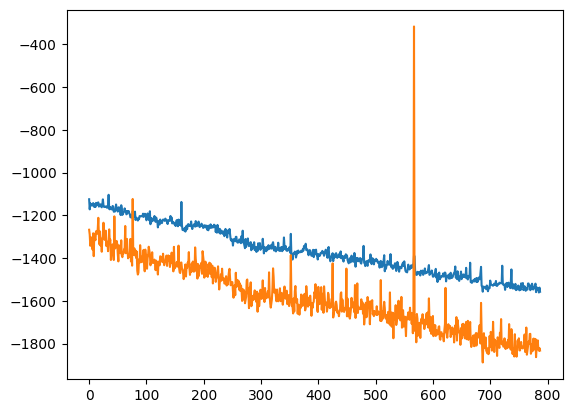

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-25 22:36:44.359894


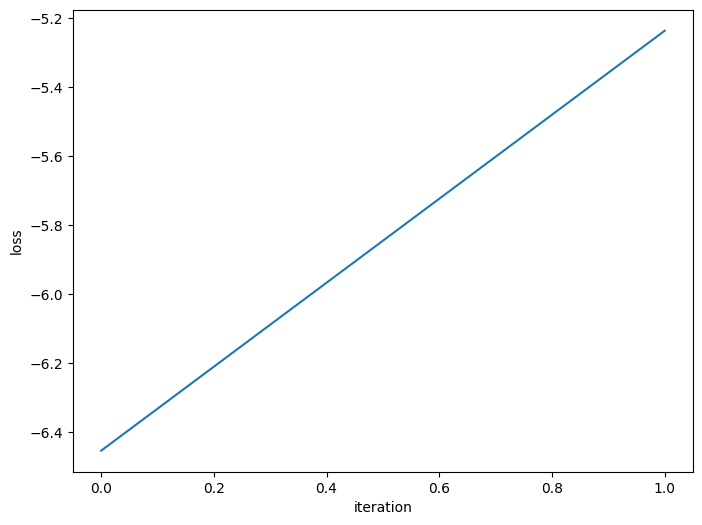

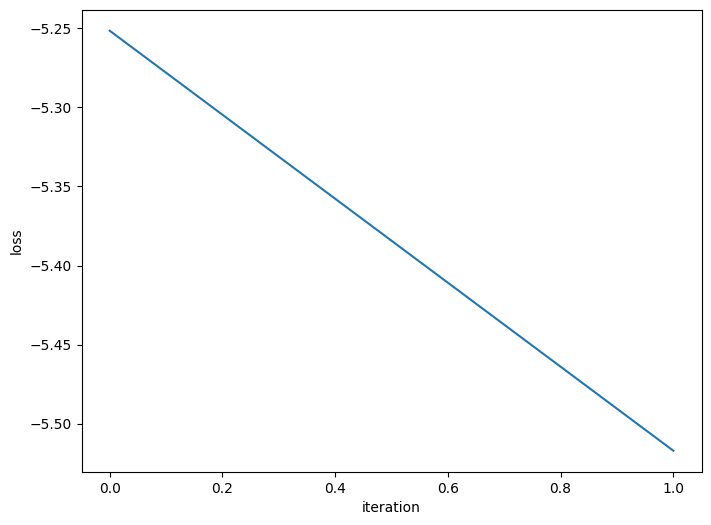

In [25]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [26]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [27]:
policy_evaluation_iter=2

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24
predict diverge [ 6.93118768  8.3011962   0.42464272 -1.18378664] [0.10715762 0.10039656 0.0135034  0.0619057 ] [17.218779  8.220233 54.91965  24.885656] [ 8.609389   4.1101165 27.459826  12.442828 ] sim_timestep 164

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71
predict diverge [ -2.53738251  -2.99569641 -10.64616822 -26.32343209] [-0.03548151 -0.80013871 -0.35410976 -3.48208182] [17.218779  8.220233 54.91965  24.885656] [ 8.609389   4.1101165 27.459826  12.442828 ] sim_timestep 159

 72

 73

 74

 75
predict diverge [ 5.09596481  8.32409492  0.52399917 -0.7358402 ] [0.04806707 0.17301083 0.01060202 0.08675444] [17.218779  8.220233 54.91965  24.885656] [ 8.609389   4.1101165 27.459826  

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.86794  validloss 1.07815±0.00000  bestvalidloss 1.07815  last_update 0
train: iter 1  trainloss 0.77513  validloss 0.92908±0.00000  bestvalidloss 0.92908  last_update 0
train: iter 2  trainloss 0.74706  validloss 0.88782±0.00000  bestvalidloss 0.88782  last_update 0
train: iter 3  trainloss 0.71961  validloss 0.87045±0.00000  bestvalidloss 0.87045  last_update 0
train: iter 4  trainloss 0.70983  validloss 0.88961±0.00000  bestvalidloss 0.87045  last_update 1
train: iter 5  trainloss 0.70981  validloss 0.87755±0.00000  bestvalidloss 0.87045  last_update 2
train: iter 6  trainloss 0.69237  validloss 0.83540±0.00000  bestvalidloss 0.83540  last_update 0
train: iter 7  trainloss 0.69173  validloss 0.83804±0.00000  bestvalidloss 0.83540  last_update 1
train: iter 8  trainloss 0.67881  validloss 0.84809±0.00000  bestvalidloss 0.83540  last_update 2
train: iter 9  trainloss 0.68863  validloss 0.85058±0.00000  bestvalidloss 0.83540  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.58774  validloss 0.78499±0.00000  bestvalidloss 0.78131  last_update 9
train: iter 84  trainloss 0.58480  validloss 0.79554±0.00000  bestvalidloss 0.78131  last_update 10
train: iter 85  trainloss 0.58756  validloss 0.79135±0.00000  bestvalidloss 0.78131  last_update 11
train: iter 86  trainloss 0.58102  validloss 0.78075±0.00000  bestvalidloss 0.78075  last_update 0
train: iter 87  trainloss 0.58507  validloss 0.82206±0.00000  bestvalidloss 0.78075  last_update 1
train: iter 88  trainloss 0.58693  validloss 0.81582±0.00000  bestvalidloss 0.78075  last_update 2
train: iter 89  trainloss 0.58637  validloss 0.79596±0.00000  bestvalidloss 0.78075  last_update 3
train: iter 90  trainloss 0.57727  validloss 0.78731±0.00000  bestvalidloss 0.78075  last_update 4
train: iter 91  trainloss 0.58901  validloss 0.81521±0.00000  bestvalidloss 0.78075  last_update 5
train: iter 92  trainloss 0.57999  validloss 0.78903±0.00000  bestvalidloss 0.78075  last_update 6
train: i

train: iter 166  trainloss 0.54774  validloss 0.79525±0.00000  bestvalidloss 0.77374  last_update 51
train: iter 167  trainloss 0.55206  validloss 0.81857±0.00000  bestvalidloss 0.77374  last_update 52
train: iter 168  trainloss 0.55032  validloss 0.79500±0.00000  bestvalidloss 0.77374  last_update 53
train: iter 169  trainloss 0.55056  validloss 0.81376±0.00000  bestvalidloss 0.77374  last_update 54
train: iter 170  trainloss 0.55328  validloss 0.79846±0.00000  bestvalidloss 0.77374  last_update 55
train: iter 171  trainloss 0.55264  validloss 0.80550±0.00000  bestvalidloss 0.77374  last_update 56
train: iter 172  trainloss 0.55320  validloss 0.80841±0.00000  bestvalidloss 0.77374  last_update 57
train: iter 173  trainloss 0.55097  validloss 0.81931±0.00000  bestvalidloss 0.77374  last_update 58
train: iter 174  trainloss 0.54900  validloss 0.78012±0.00000  bestvalidloss 0.77374  last_update 59
train: iter 175  trainloss 0.55210  validloss 0.78739±0.00000  bestvalidloss 0.77374  last_

In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.353162912523746
valid_loss:  -11.65510737915039
weight_alpha 1.0 h_min_tilde -12.321254 ell_tilde -7.413551805849075 kappa_tilde 0.0004513993290753069
train_loss:  -6.084175536727905
valid_loss:  -7.462405183410645
weight_alpha 0.2 h_min_tilde -12.321254 ell_tilde -6.359821466064453 kappa_tilde 0.0004095667495624008


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1185.91145  validloss -1511.91138±0.00000  bestvalidloss -1511.91138  last_update 0
train: iter 1  trainloss -1200.36124  validloss -1402.23173±0.00000  bestvalidloss -1511.91138  last_update 1
train: iter 2  trainloss -1196.33069  validloss -1491.60002±0.00000  bestvalidloss -1511.91138  last_update 2
train: iter 3  trainloss -1181.08797  validloss -1410.03560±0.00000  bestvalidloss -1511.91138  last_update 3
train: iter 4  trainloss -1205.93357  validloss -1467.87152±0.00000  bestvalidloss -1511.91138  last_update 4
train: iter 5  trainloss -1213.92231  validloss -1469.64377±0.00000  bestvalidloss -1511.91138  last_update 5
train: iter 6  trainloss -1204.45561  validloss -1457.66841±0.00000  bestvalidloss -1511.91138  last_update 6
train: iter 7  trainloss -1188.92917  validloss -1457.99467±0.00000  bestvalidloss -1511.91138  last_update 7
train: iter 8  trainloss -1182.72232  validloss -1373.25751±0.00000  bestva

train: iter 74  trainloss -1220.22744  validloss -1526.46919±0.00000  bestvalidloss -1575.61169  last_update 54
train: iter 75  trainloss -1214.60421  validloss -1516.79687±0.00000  bestvalidloss -1575.61169  last_update 55
train: iter 76  trainloss -1247.40038  validloss -1401.10032±0.00000  bestvalidloss -1575.61169  last_update 56
train: iter 77  trainloss -1235.50969  validloss -1570.01288±0.00000  bestvalidloss -1575.61169  last_update 57
train: iter 78  trainloss -1230.69111  validloss -1544.20956±0.00000  bestvalidloss -1575.61169  last_update 58
train: iter 79  trainloss -1158.80555  validloss -1468.43180±0.00000  bestvalidloss -1575.61169  last_update 59
train: iter 80  trainloss -1228.40598  validloss -1529.20886±0.00000  bestvalidloss -1575.61169  last_update 60
train: iter 81  trainloss -1245.43316  validloss -1542.31649±0.00000  bestvalidloss -1575.61169  last_update 61
train: iter 82  trainloss -1234.51956  validloss -1501.61881±0.00000  bestvalidloss -1575.61169  last_up

train: iter 148  trainloss -1272.55743  validloss -1579.23015±0.00000  bestvalidloss -1621.31261  last_update 17
train: iter 149  trainloss -1267.91014  validloss -1557.79918±0.00000  bestvalidloss -1621.31261  last_update 18
train: iter 150  trainloss -1283.20072  validloss -1539.08886±0.00000  bestvalidloss -1621.31261  last_update 19
train: iter 151  trainloss -1273.91002  validloss -1545.19602±0.00000  bestvalidloss -1621.31261  last_update 20
train: iter 152  trainloss -1277.12310  validloss -1606.15070±0.00000  bestvalidloss -1621.31261  last_update 21
train: iter 153  trainloss -1277.23939  validloss -1593.46259±0.00000  bestvalidloss -1621.31261  last_update 22
train: iter 154  trainloss -1262.27085  validloss -1603.33924±0.00000  bestvalidloss -1621.31261  last_update 23
train: iter 155  trainloss -1272.07237  validloss -1580.31070±0.00000  bestvalidloss -1621.31261  last_update 24
train: iter 156  trainloss -1279.04235  validloss -1625.29079±0.00000  bestvalidloss -1625.29079

train: iter 221  trainloss -1264.44186  validloss -1618.04798±0.00000  bestvalidloss -1674.16998  last_update 49
train: iter 222  trainloss -1317.78938  validloss -1680.26605±0.00000  bestvalidloss -1680.26605  last_update 0
train: iter 223  trainloss -1319.65811  validloss -1649.06396±0.00000  bestvalidloss -1680.26605  last_update 1
train: iter 224  trainloss -1315.78221  validloss -1644.99756±0.00000  bestvalidloss -1680.26605  last_update 2
train: iter 225  trainloss -1318.37232  validloss -1629.54312±0.00000  bestvalidloss -1680.26605  last_update 3
train: iter 226  trainloss -1321.28630  validloss -1591.70298±0.00000  bestvalidloss -1680.26605  last_update 4
train: iter 227  trainloss -1295.10905  validloss -1669.04142±0.00000  bestvalidloss -1680.26605  last_update 5
train: iter 228  trainloss -1268.09334  validloss -1570.65092±0.00000  bestvalidloss -1680.26605  last_update 6
train: iter 229  trainloss -1308.24663  validloss -1599.26216±0.00000  bestvalidloss -1680.26605  last_

train: iter 294  trainloss -1337.05791  validloss -1640.36012±0.00000  bestvalidloss -1715.26551  last_update 36
train: iter 295  trainloss -1347.18818  validloss -1640.51643±0.00000  bestvalidloss -1715.26551  last_update 37
train: iter 296  trainloss -1330.80459  validloss -1676.82149±0.00000  bestvalidloss -1715.26551  last_update 38
train: iter 297  trainloss -1331.43758  validloss -1636.08309±0.00000  bestvalidloss -1715.26551  last_update 39
train: iter 298  trainloss -1327.59584  validloss -1613.47073±0.00000  bestvalidloss -1715.26551  last_update 40
train: iter 299  trainloss -1344.16500  validloss -1649.72722±0.00000  bestvalidloss -1715.26551  last_update 41
train: iter 300  trainloss -1328.38581  validloss -1667.12495±0.00000  bestvalidloss -1715.26551  last_update 42
train: iter 301  trainloss -1325.67538  validloss -1661.27976±0.00000  bestvalidloss -1715.26551  last_update 43
train: iter 302  trainloss -1295.75221  validloss -1627.78543±0.00000  bestvalidloss -1715.26551

train: iter 367  trainloss -1363.07590  validloss -1701.78335±0.00000  bestvalidloss -1741.09555  last_update 33
train: iter 368  trainloss -1365.13774  validloss -1709.41907±0.00000  bestvalidloss -1741.09555  last_update 34
train: iter 369  trainloss -1374.57309  validloss -1724.71964±0.00000  bestvalidloss -1741.09555  last_update 35
train: iter 370  trainloss -1350.00205  validloss -1490.48664±0.00000  bestvalidloss -1741.09555  last_update 36
train: iter 371  trainloss -1378.51752  validloss -1725.04209±0.00000  bestvalidloss -1741.09555  last_update 37
train: iter 372  trainloss -1390.89024  validloss -1704.27781±0.00000  bestvalidloss -1741.09555  last_update 38
train: iter 373  trainloss -1377.74919  validloss -1724.52005±0.00000  bestvalidloss -1741.09555  last_update 39
train: iter 374  trainloss -1378.85965  validloss -1655.40324±0.00000  bestvalidloss -1741.09555  last_update 40
train: iter 375  trainloss -1382.59493  validloss -1647.49575±0.00000  bestvalidloss -1741.09555

train: iter 440  trainloss -1401.14912  validloss -1708.50789±0.00000  bestvalidloss -1800.51758  last_update 12
train: iter 441  trainloss -1389.03369  validloss -1731.27786±0.00000  bestvalidloss -1800.51758  last_update 13
train: iter 442  trainloss -1399.94482  validloss -1723.18926±0.00000  bestvalidloss -1800.51758  last_update 14
train: iter 443  trainloss -1363.77557  validloss -1681.84815±0.00000  bestvalidloss -1800.51758  last_update 15
train: iter 444  trainloss -1407.43780  validloss -1710.08625±0.00000  bestvalidloss -1800.51758  last_update 16
train: iter 445  trainloss -1409.40055  validloss -1764.47781±0.00000  bestvalidloss -1800.51758  last_update 17
train: iter 446  trainloss -1418.31760  validloss -1760.07598±0.00000  bestvalidloss -1800.51758  last_update 18
train: iter 447  trainloss -1375.44260  validloss -1671.19991±0.00000  bestvalidloss -1800.51758  last_update 19
train: iter 448  trainloss -1408.36960  validloss -1690.59973±0.00000  bestvalidloss -1800.51758

train: iter 513  trainloss -1404.54150  validloss -1731.53990±0.00000  bestvalidloss -1807.44462  last_update 9
train: iter 514  trainloss -1419.64308  validloss -1738.23582±0.00000  bestvalidloss -1807.44462  last_update 10
train: iter 515  trainloss -1437.03274  validloss -1788.62296±0.00000  bestvalidloss -1807.44462  last_update 11
train: iter 516  trainloss -1416.76592  validloss -1762.27081±0.00000  bestvalidloss -1807.44462  last_update 12
train: iter 517  trainloss -1430.37526  validloss -1755.98983±0.00000  bestvalidloss -1807.44462  last_update 13
train: iter 518  trainloss -1433.47902  validloss -1749.17943±0.00000  bestvalidloss -1807.44462  last_update 14
train: iter 519  trainloss -1397.36854  validloss -1700.16405±0.00000  bestvalidloss -1807.44462  last_update 15
train: iter 520  trainloss -1418.00188  validloss -1753.11102±0.00000  bestvalidloss -1807.44462  last_update 16
train: iter 521  trainloss -1418.92355  validloss -1718.16680±0.00000  bestvalidloss -1807.44462 

train: iter 586  trainloss -1464.32370  validloss -1781.10511±0.00000  bestvalidloss -1821.47413  last_update 61
train: iter 587  trainloss -1450.89153  validloss -1793.21156±0.00000  bestvalidloss -1821.47413  last_update 62
train: iter 588  trainloss -1447.31992  validloss -1775.52625±0.00000  bestvalidloss -1821.47413  last_update 63
train: iter 589  trainloss -1467.38966  validloss -1770.13849±0.00000  bestvalidloss -1821.47413  last_update 64
train: iter 590  trainloss -1456.51576  validloss -1811.98779±0.00000  bestvalidloss -1821.47413  last_update 65
train: iter 591  trainloss -1465.18575  validloss -1761.08648±0.00000  bestvalidloss -1821.47413  last_update 66
train: iter 592  trainloss -1438.02823  validloss -1790.62286±0.00000  bestvalidloss -1821.47413  last_update 67
train: iter 593  trainloss -1451.90187  validloss -1807.31647±0.00000  bestvalidloss -1821.47413  last_update 68
train: iter 594  trainloss -1467.86756  validloss -1814.03184±0.00000  bestvalidloss -1821.47413

train: iter 659  trainloss -1475.84571  validloss -1792.05290±0.00000  bestvalidloss -1855.96225  last_update 44
train: iter 660  trainloss -1471.96008  validloss -1798.64406±0.00000  bestvalidloss -1855.96225  last_update 45
train: iter 661  trainloss -1486.36727  validloss -1793.50776±0.00000  bestvalidloss -1855.96225  last_update 46
train: iter 662  trainloss -1479.55065  validloss -1835.60580±0.00000  bestvalidloss -1855.96225  last_update 47
train: iter 663  trainloss -1473.87169  validloss -1781.09773±0.00000  bestvalidloss -1855.96225  last_update 48
train: iter 664  trainloss -1428.45720  validloss -1824.79449±0.00000  bestvalidloss -1855.96225  last_update 49
train: iter 665  trainloss -1449.44553  validloss -1790.32310±0.00000  bestvalidloss -1855.96225  last_update 50
train: iter 666  trainloss -1474.42952  validloss -1837.81592±0.00000  bestvalidloss -1855.96225  last_update 51
train: iter 667  trainloss -1491.06739  validloss -1820.95032±0.00000  bestvalidloss -1855.96225

train: iter 732  trainloss -1468.04358  validloss -1689.04108±0.00000  bestvalidloss -1895.03435  last_update 25
train: iter 733  trainloss -1506.01623  validloss -1832.78151±0.00000  bestvalidloss -1895.03435  last_update 26
train: iter 734  trainloss -1506.43795  validloss -1844.86265±0.00000  bestvalidloss -1895.03435  last_update 27
train: iter 735  trainloss -1499.29060  validloss -1847.82491±0.00000  bestvalidloss -1895.03435  last_update 28
train: iter 736  trainloss -1503.68926  validloss -1867.63203±0.00000  bestvalidloss -1895.03435  last_update 29
train: iter 737  trainloss -1505.77250  validloss -1859.48222±0.00000  bestvalidloss -1895.03435  last_update 30
train: iter 738  trainloss -1495.54938  validloss -1827.23055±0.00000  bestvalidloss -1895.03435  last_update 31
train: iter 739  trainloss -1506.56425  validloss -1849.01643±0.00000  bestvalidloss -1895.03435  last_update 32
train: iter 740  trainloss -1496.46096  validloss -1809.03577±0.00000  bestvalidloss -1895.03435

train: iter 805  trainloss -1542.16169  validloss -1890.38503±0.00000  bestvalidloss -1937.13883  last_update 10
train: iter 806  trainloss -1531.97540  validloss -1854.67825±0.00000  bestvalidloss -1937.13883  last_update 11
train: iter 807  trainloss -1545.33679  validloss -1860.69977±0.00000  bestvalidloss -1937.13883  last_update 12
train: iter 808  trainloss -1504.67888  validloss -1876.28699±0.00000  bestvalidloss -1937.13883  last_update 13
train: iter 809  trainloss -1483.24867  validloss -1862.38594±0.00000  bestvalidloss -1937.13883  last_update 14
train: iter 810  trainloss -1526.55103  validloss -1850.87224±0.00000  bestvalidloss -1937.13883  last_update 15
train: iter 811  trainloss -1527.08409  validloss -1859.91174±0.00000  bestvalidloss -1937.13883  last_update 16
train: iter 812  trainloss -1528.83910  validloss -1870.12537±0.00000  bestvalidloss -1937.13883  last_update 17
train: iter 813  trainloss -1524.41220  validloss -1851.02175±0.00000  bestvalidloss -1937.13883

train: iter 878  trainloss -1606.87926  validloss -1960.16814±0.00000  bestvalidloss -2015.64356  last_update 8
train: iter 879  trainloss -1622.04868  validloss -1962.20280±0.00000  bestvalidloss -2015.64356  last_update 9
train: iter 880  trainloss -1623.14404  validloss -1958.44328±0.00000  bestvalidloss -2015.64356  last_update 10
train: iter 881  trainloss -1615.52093  validloss -1927.15630±0.00000  bestvalidloss -2015.64356  last_update 11
train: iter 882  trainloss -1607.62459  validloss -1948.24228±0.00000  bestvalidloss -2015.64356  last_update 12
train: iter 883  trainloss -1611.05110  validloss -1966.74628±0.00000  bestvalidloss -2015.64356  last_update 13
train: iter 884  trainloss -1610.12198  validloss -1961.35766±0.00000  bestvalidloss -2015.64356  last_update 14
train: iter 885  trainloss -1603.00049  validloss -1985.38398±0.00000  bestvalidloss -2015.64356  last_update 15
train: iter 886  trainloss -1588.07027  validloss -1930.05808±0.00000  bestvalidloss -2015.64356  

train: iter 951  trainloss -1608.10875  validloss -1930.36649±0.00000  bestvalidloss -2015.64356  last_update 81
train: iter 952  trainloss -1609.14103  validloss -1937.88476±0.00000  bestvalidloss -2015.64356  last_update 82
train: iter 953  trainloss -1605.09582  validloss -1900.18884±0.00000  bestvalidloss -2015.64356  last_update 83
train: iter 954  trainloss -1601.06226  validloss -1899.45269±0.00000  bestvalidloss -2015.64356  last_update 84
train: iter 955  trainloss -1601.55343  validloss -1961.86383±0.00000  bestvalidloss -2015.64356  last_update 85
train: iter 956  trainloss -1588.43196  validloss -1907.96006±0.00000  bestvalidloss -2015.64356  last_update 86
train: iter 957  trainloss -1601.51539  validloss -1965.94674±0.00000  bestvalidloss -2015.64356  last_update 87
train: iter 958  trainloss -1602.49951  validloss -1961.20800±0.00000  bestvalidloss -2015.64356  last_update 88
train: iter 959  trainloss -1588.06848  validloss -1871.12468±0.00000  bestvalidloss -2015.64356

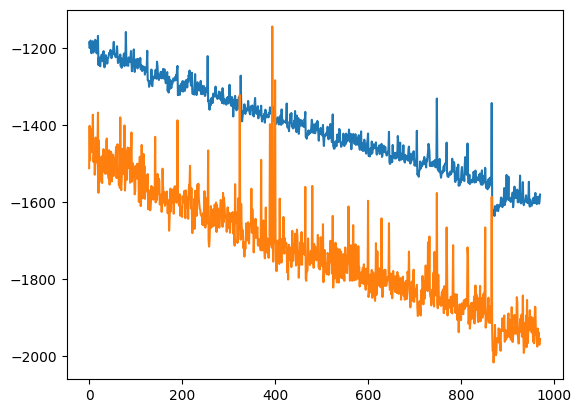

alpha 0.2 default_lr 0.0005


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [33]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [34]:
print(datetime.datetime.now())

2023-07-25 22:59:48.027366


In [ ]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# Iter 4

In [35]:
policy_evaluation_iter=3

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.74817  validloss 1.18141±0.00000  bestvalidloss 1.18141  last_update 0
train: iter 1  trainloss 0.68336  validloss 0.91249±0.00000  bestvalidloss 0.91249  last_update 0
train: iter 2  trainloss 0.65733  validloss 0.87552±0.00000  bestvalidloss 0.87552  last_update 0
train: iter 3  trainloss 0.64751  validloss 0.85538±0.00000  bestvalidloss 0.85538  last_update 0
train: iter 4  trainloss 0.64225  validloss 0.86540±0.00000  bestvalidloss 0.85538  last_update 1
train: iter 5  trainloss 0.63660  validloss 0.84319±0.00000  bestvalidloss 0.84319  last_update 0
train: iter 6  trainloss 0.63194  validloss 0.84649±0.00000  bestvalidloss 0.84319  last_update 1
train: iter 7  trainloss 0.62787  validloss 0.83415±0.00000  bestvalidloss 0.83415  last_update 0
train: iter 8  trainloss 0.62923  validloss 0.82983±0.00000  bestvalidloss 0.82983  last_update 0
train: iter 9  trainloss 0.62347  validloss 0.84700±0.00000  bestvalidloss 0.82983  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.56232  validloss 0.78938±0.00000  bestvalidloss 0.78288  last_update 3
train: iter 84  trainloss 0.56079  validloss 0.80092±0.00000  bestvalidloss 0.78288  last_update 4
train: iter 85  trainloss 0.56405  validloss 0.79315±0.00000  bestvalidloss 0.78288  last_update 5
train: iter 86  trainloss 0.56003  validloss 0.80137±0.00000  bestvalidloss 0.78288  last_update 6
train: iter 87  trainloss 0.56195  validloss 0.80570±0.00000  bestvalidloss 0.78288  last_update 7
train: iter 88  trainloss 0.56820  validloss 0.83715±0.00000  bestvalidloss 0.78288  last_update 8
train: iter 89  trainloss 0.55708  validloss 0.81539±0.00000  bestvalidloss 0.78288  last_update 9
train: iter 90  trainloss 0.55808  validloss 0.81019±0.00000  bestvalidloss 0.78288  last_update 10
train: iter 91  trainloss 0.55748  validloss 0.81295±0.00000  bestvalidloss 0.78288  last_update 11
train: iter 92  trainloss 0.55586  validloss 0.80711±0.00000  bestvalidloss 0.78288  last_update 12
train: 

train: iter 165  trainloss 0.54020  validloss 0.81791±0.00000  bestvalidloss 0.77823  last_update 63
train: iter 166  trainloss 0.54022  validloss 0.81878±0.00000  bestvalidloss 0.77823  last_update 64
train: iter 167  trainloss 0.53567  validloss 0.79300±0.00000  bestvalidloss 0.77823  last_update 65
train: iter 168  trainloss 0.54072  validloss 0.81188±0.00000  bestvalidloss 0.77823  last_update 66
train: iter 169  trainloss 0.53695  validloss 0.85146±0.00000  bestvalidloss 0.77823  last_update 67
train: iter 170  trainloss 0.53391  validloss 0.84650±0.00000  bestvalidloss 0.77823  last_update 68
train: iter 171  trainloss 0.53656  validloss 0.82157±0.00000  bestvalidloss 0.77823  last_update 69
train: iter 172  trainloss 0.53869  validloss 0.86027±0.00000  bestvalidloss 0.77823  last_update 70
train: iter 173  trainloss 0.53328  validloss 0.81571±0.00000  bestvalidloss 0.77823  last_update 71
train: iter 174  trainloss 0.53586  validloss 0.81075±0.00000  bestvalidloss 0.77823  last_

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.089028648763895
valid_loss:  -15.236666320419308
weight_alpha 1.0 h_min_tilde -12.323741 ell_tilde -8.718556183094977 kappa_tilde 0.000526667156028829
train_loss:  -6.21752569026947
valid_loss:  -7.930116047668458
weight_alpha 0.2 h_min_tilde -12.323741 ell_tilde -6.5600437617492675 kappa_tilde 0.0004165330071427589


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1227.06906  validloss -1576.35746±0.00000  bestvalidloss -1576.35746  last_update 0
train: iter 1  trainloss -1241.26986  validloss -1594.79878±0.00000  bestvalidloss -1594.79878  last_update 0
train: iter 2  trainloss -1246.21940  validloss -1601.15535±0.00000  bestvalidloss -1601.15535  last_update 0
train: iter 3  trainloss -1236.89572  validloss -1620.70318±0.00000  bestvalidloss -1620.70318  last_update 0
train: iter 4  trainloss -1230.78219  validloss -1478.22853±0.00000  bestvalidloss -1620.70318  last_update 1
train: iter 5  trainloss -1238.12707  validloss -1588.64167±0.00000  bestvalidloss -1620.70318  last_update 2
train: iter 6  trainloss -1262.93881  validloss -1569.78883±0.00000  bestvalidloss -1620.70318  last_update 3
train: iter 7  trainloss -1259.63745  validloss -1594.97079±0.00000  bestvalidloss -1620.70318  last_update 4
train: iter 8  trainloss -1243.59106  validloss -1596.06816±0.00000  bestva

train: iter 74  trainloss -1260.14842  validloss -1523.17494±0.00000  bestvalidloss -1644.43502  last_update 64
train: iter 75  trainloss -1257.73470  validloss -1588.33078±0.00000  bestvalidloss -1644.43502  last_update 65
train: iter 76  trainloss -1261.42217  validloss -1565.95019±0.00000  bestvalidloss -1644.43502  last_update 66
train: iter 77  trainloss -1254.58074  validloss -1607.36532±0.00000  bestvalidloss -1644.43502  last_update 67
train: iter 78  trainloss -1271.30983  validloss -1617.60747±0.00000  bestvalidloss -1644.43502  last_update 68
train: iter 79  trainloss -1246.75555  validloss -1526.33954±0.00000  bestvalidloss -1644.43502  last_update 69
train: iter 80  trainloss -1267.80154  validloss -1573.70135±0.00000  bestvalidloss -1644.43502  last_update 70
train: iter 81  trainloss -1253.47218  validloss -1608.63396±0.00000  bestvalidloss -1644.43502  last_update 71
train: iter 82  trainloss -1256.57510  validloss -1475.64768±0.00000  bestvalidloss -1644.43502  last_up

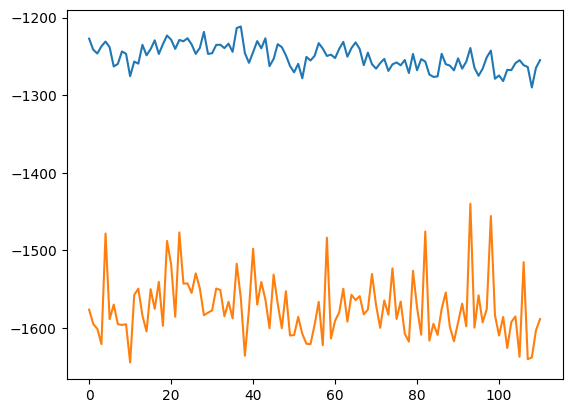

alpha 0.2 default_lr 0.0005


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [41]:
print(datetime.datetime.now())

2023-07-25 23:20:13.223919


In [ ]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# Iter 5

In [42]:
policy_evaluation_iter=4

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55
predict diverge [-0.54841893 -8.3008172  -8.70174766 23.24465778] [-0.11894691 -0.12100429  0.34074501  0.6667251 ] [17.218779  8.220233 54.91965  24.885656] [ 8.609389   4.1101165 27.459826  12.442828 ] sim_timestep 127

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75
predict diverge [ -2.0939303   -8.26613512 -10.41494343  20.4749916 ] [-0.08189737 -0.0590728   0.31784388  1.71262964] [17.218779  8.220233 54.91965  24.885656] [ 8.609389   4.1101165 27.459826  12.442828 ] sim_timestep 103

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88
predict diverge [-0.45790833 -8.41655649 -9.81572501 18.97921881] [-0.07011237 -0.47053969  0.296227    1.82306863] [17

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.64997  validloss 0.90171±0.00000  bestvalidloss 0.90171  last_update 0
train: iter 1  trainloss 0.60841  validloss 0.84441±0.00000  bestvalidloss 0.84441  last_update 0
train: iter 2  trainloss 0.60070  validloss 0.87781±0.00000  bestvalidloss 0.84441  last_update 1
train: iter 3  trainloss 0.58953  validloss 0.85438±0.00000  bestvalidloss 0.84441  last_update 2
train: iter 4  trainloss 0.58646  validloss 0.85555±0.00000  bestvalidloss 0.84441  last_update 3
train: iter 5  trainloss 0.58232  validloss 0.84472±0.00000  bestvalidloss 0.84441  last_update 4
train: iter 6  trainloss 0.58123  validloss 0.84986±0.00000  bestvalidloss 0.84441  last_update 5
train: iter 7  trainloss 0.58512  validloss 0.84288±0.00000  bestvalidloss 0.84288  last_update 0
train: iter 8  trainloss 0.57832  validloss 0.83067±0.00000  bestvalidloss 0.83067  last_update 0
train: iter 9  trainloss 0.57077  validloss 0.83312±0.00000  bestvalidloss 0.83067  last_update 1
train: iter 10  trai

train: iter 84  trainloss 0.52758  validloss 0.83469±0.00000  bestvalidloss 0.79867  last_update 42
train: iter 85  trainloss 0.52892  validloss 0.81405±0.00000  bestvalidloss 0.79867  last_update 43
train: iter 86  trainloss 0.52452  validloss 0.82451±0.00000  bestvalidloss 0.79867  last_update 44
train: iter 87  trainloss 0.52252  validloss 0.82965±0.00000  bestvalidloss 0.79867  last_update 45
train: iter 88  trainloss 0.52456  validloss 0.80262±0.00000  bestvalidloss 0.79867  last_update 46
train: iter 89  trainloss 0.52543  validloss 0.82144±0.00000  bestvalidloss 0.79867  last_update 47
train: iter 90  trainloss 0.52452  validloss 0.82754±0.00000  bestvalidloss 0.79867  last_update 48
train: iter 91  trainloss 0.52534  validloss 0.82855±0.00000  bestvalidloss 0.79867  last_update 49
train: iter 92  trainloss 0.52291  validloss 0.81563±0.00000  bestvalidloss 0.79867  last_update 50
train: iter 93  trainloss 0.52440  validloss 0.82846±0.00000  bestvalidloss 0.79867  last_update 51


train: iter 166  trainloss 0.50134  validloss 0.80578±0.00000  bestvalidloss 0.79306  last_update 34
train: iter 167  trainloss 0.50781  validloss 0.83623±0.00000  bestvalidloss 0.79306  last_update 35
train: iter 168  trainloss 0.49720  validloss 0.81376±0.00000  bestvalidloss 0.79306  last_update 36
train: iter 169  trainloss 0.49967  validloss 0.87238±0.00000  bestvalidloss 0.79306  last_update 37
train: iter 170  trainloss 0.51369  validloss 0.81642±0.00000  bestvalidloss 0.79306  last_update 38
train: iter 171  trainloss 0.50382  validloss 0.82196±0.00000  bestvalidloss 0.79306  last_update 39
train: iter 172  trainloss 0.50491  validloss 0.82672±0.00000  bestvalidloss 0.79306  last_update 40
train: iter 173  trainloss 0.50158  validloss 0.84957±0.00000  bestvalidloss 0.79306  last_update 41
train: iter 174  trainloss 0.50362  validloss 0.84313±0.00000  bestvalidloss 0.79306  last_update 42
train: iter 175  trainloss 0.50793  validloss 0.83270±0.00000  bestvalidloss 0.79306  last_

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.811890918096902
valid_loss:  -15.463185743141173
weight_alpha 1.0 h_min_tilde -12.324074 ell_tilde -8.542149883105756 kappa_tilde 0.0005142136567356054
train_loss:  -5.828865969085694
valid_loss:  -7.778116785430908
weight_alpha 0.2 h_min_tilde -12.324074 ell_tilde -6.218716132354737 kappa_tilde 0.0004047104745256597


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1157.61581  validloss -1547.10911±0.00000  bestvalidloss -1547.10911  last_update 0
train: iter 1  trainloss -1153.33791  validloss -1564.13724±0.00000  bestvalidloss -1564.13724  last_update 0
train: iter 2  trainloss -1220.57779  validloss -1644.08409±0.00000  bestvalidloss -1644.08409  last_update 0
train: iter 3  trainloss -1207.19919  validloss -1601.34425±0.00000  bestvalidloss -1644.08409  last_update 1
train: iter 4  trainloss -1204.44253  validloss -1596.97022±0.00000  bestvalidloss -1644.08409  last_update 2
train: iter 5  trainloss -1229.00854  validloss -1588.55630±0.00000  bestvalidloss -1644.08409  last_update 3
train: iter 6  trainloss -1210.46674  validloss -1582.92531±0.00000  bestvalidloss -1644.08409  last_update 4
train: iter 7  trainloss -1212.43315  validloss -1621.28797±0.00000  bestvalidloss -1644.08409  last_update 5
train: iter 8  trainloss -1195.23712  validloss -1569.35365±0.00000  bestva

train: iter 74  trainloss -1237.39093  validloss -1632.40050±0.00000  bestvalidloss -1663.45113  last_update 56
train: iter 75  trainloss -1210.56123  validloss -1623.14353±0.00000  bestvalidloss -1663.45113  last_update 57
train: iter 76  trainloss -1214.63180  validloss -1626.59175±0.00000  bestvalidloss -1663.45113  last_update 58
train: iter 77  trainloss -1220.67679  validloss -1636.07702±0.00000  bestvalidloss -1663.45113  last_update 59
train: iter 78  trainloss -1218.37761  validloss -1588.34093±0.00000  bestvalidloss -1663.45113  last_update 60
train: iter 79  trainloss -1206.28495  validloss -1596.95951±0.00000  bestvalidloss -1663.45113  last_update 61
train: iter 80  trainloss -1216.30270  validloss -1242.57885±0.00000  bestvalidloss -1663.45113  last_update 62
train: iter 81  trainloss -1250.07384  validloss -1648.94285±0.00000  bestvalidloss -1663.45113  last_update 63
train: iter 82  trainloss -1240.00495  validloss -1575.77769±0.00000  bestvalidloss -1663.45113  last_up

train: iter 147  trainloss -1258.69493  validloss -1606.86144±0.00000  bestvalidloss -1699.65721  last_update 62
train: iter 148  trainloss -1231.35515  validloss -1655.69503±0.00000  bestvalidloss -1699.65721  last_update 63
train: iter 149  trainloss -1229.69595  validloss -1659.89571±0.00000  bestvalidloss -1699.65721  last_update 64
train: iter 150  trainloss -1232.73962  validloss -1665.41856±0.00000  bestvalidloss -1699.65721  last_update 65
train: iter 151  trainloss -1262.27488  validloss -1672.75399±0.00000  bestvalidloss -1699.65721  last_update 66
train: iter 152  trainloss -1263.39065  validloss -1652.23390±0.00000  bestvalidloss -1699.65721  last_update 67
train: iter 153  trainloss -1242.54230  validloss -1626.96681±0.00000  bestvalidloss -1699.65721  last_update 68
train: iter 154  trainloss -1244.75187  validloss -1611.76728±0.00000  bestvalidloss -1699.65721  last_update 69
train: iter 155  trainloss -1250.01615  validloss -1646.50153±0.00000  bestvalidloss -1699.65721

train: iter 220  trainloss -1252.51838  validloss -1677.22648±0.00000  bestvalidloss -1724.29058  last_update 54
train: iter 221  trainloss -1263.08056  validloss -1636.33679±0.00000  bestvalidloss -1724.29058  last_update 55
train: iter 222  trainloss -1270.33800  validloss -1667.10547±0.00000  bestvalidloss -1724.29058  last_update 56
train: iter 223  trainloss -1263.60452  validloss -1649.84656±0.00000  bestvalidloss -1724.29058  last_update 57
train: iter 224  trainloss -1274.29550  validloss -1724.78026±0.00000  bestvalidloss -1724.78026  last_update 0
train: iter 225  trainloss -1275.54937  validloss -1588.30504±0.00000  bestvalidloss -1724.78026  last_update 1
train: iter 226  trainloss -1290.92217  validloss -1714.94531±0.00000  bestvalidloss -1724.78026  last_update 2
train: iter 227  trainloss -1281.36992  validloss -1665.64595±0.00000  bestvalidloss -1724.78026  last_update 3
train: iter 228  trainloss -1285.30362  validloss -1618.54652±0.00000  bestvalidloss -1724.78026  la

train: iter 293  trainloss -1282.31857  validloss -1712.18296±0.00000  bestvalidloss -1734.98985  last_update 38
train: iter 294  trainloss -1279.79635  validloss -1710.73974±0.00000  bestvalidloss -1734.98985  last_update 39
train: iter 295  trainloss -1270.08742  validloss -1631.81455±0.00000  bestvalidloss -1734.98985  last_update 40
train: iter 296  trainloss -1287.40596  validloss -1716.81266±0.00000  bestvalidloss -1734.98985  last_update 41
train: iter 297  trainloss -1254.24865  validloss -1692.76128±0.00000  bestvalidloss -1734.98985  last_update 42
train: iter 298  trainloss -1271.05263  validloss -1611.36647±0.00000  bestvalidloss -1734.98985  last_update 43
train: iter 299  trainloss -1267.15679  validloss -1639.79322±0.00000  bestvalidloss -1734.98985  last_update 44
train: iter 300  trainloss -1283.31410  validloss -1622.85122±0.00000  bestvalidloss -1734.98985  last_update 45
train: iter 301  trainloss -1285.82076  validloss -1707.56955±0.00000  bestvalidloss -1734.98985

train: iter 366  trainloss -1335.74888  validloss -1772.67886±0.00000  bestvalidloss -1819.34287  last_update 9
train: iter 367  trainloss -1341.89091  validloss -1753.45532±0.00000  bestvalidloss -1819.34287  last_update 10
train: iter 368  trainloss -1355.29637  validloss -1702.77300±0.00000  bestvalidloss -1819.34287  last_update 11
train: iter 369  trainloss -1333.84027  validloss -1764.38999±0.00000  bestvalidloss -1819.34287  last_update 12
train: iter 370  trainloss -1339.09017  validloss -1710.53004±0.00000  bestvalidloss -1819.34287  last_update 13
train: iter 371  trainloss -1348.25651  validloss -1762.44547±0.00000  bestvalidloss -1819.34287  last_update 14
train: iter 372  trainloss -1341.21303  validloss -1670.20243±0.00000  bestvalidloss -1819.34287  last_update 15
train: iter 373  trainloss -1342.79214  validloss -1729.80522±0.00000  bestvalidloss -1819.34287  last_update 16
train: iter 374  trainloss -1335.28287  validloss -1779.44845±0.00000  bestvalidloss -1819.34287 

train: iter 439  trainloss -1367.57252  validloss -1770.10170±0.00000  bestvalidloss -1834.19082  last_update 28
train: iter 440  trainloss -1373.71698  validloss -1730.51994±0.00000  bestvalidloss -1834.19082  last_update 29
train: iter 441  trainloss -1360.90459  validloss -1753.18764±0.00000  bestvalidloss -1834.19082  last_update 30
train: iter 442  trainloss -1356.95153  validloss -1725.95008±0.00000  bestvalidloss -1834.19082  last_update 31
train: iter 443  trainloss -1345.22550  validloss -1764.08046±0.00000  bestvalidloss -1834.19082  last_update 32
train: iter 444  trainloss -1364.84484  validloss -1739.81735±0.00000  bestvalidloss -1834.19082  last_update 33
train: iter 445  trainloss -1347.62340  validloss -1753.34312±0.00000  bestvalidloss -1834.19082  last_update 34
train: iter 446  trainloss -1358.97118  validloss -1773.02420±0.00000  bestvalidloss -1834.19082  last_update 35
train: iter 447  trainloss -1366.94518  validloss -1766.45664±0.00000  bestvalidloss -1834.19082

train: iter 512  trainloss -1387.17774  validloss -1789.13529±0.00000  bestvalidloss -1849.18162  last_update 4
train: iter 513  trainloss -1399.62701  validloss -1791.49199±0.00000  bestvalidloss -1849.18162  last_update 5
train: iter 514  trainloss -1393.60814  validloss -1817.24472±0.00000  bestvalidloss -1849.18162  last_update 6
train: iter 515  trainloss -1411.01129  validloss -1770.61923±0.00000  bestvalidloss -1849.18162  last_update 7
train: iter 516  trainloss -1397.31258  validloss -1812.02528±0.00000  bestvalidloss -1849.18162  last_update 8
train: iter 517  trainloss -1402.00985  validloss -1824.06448±0.00000  bestvalidloss -1849.18162  last_update 9
train: iter 518  trainloss -1372.28783  validloss -1785.92529±0.00000  bestvalidloss -1849.18162  last_update 10
train: iter 519  trainloss -1370.72971  validloss -1823.38377±0.00000  bestvalidloss -1849.18162  last_update 11
train: iter 520  trainloss -1373.85951  validloss -1784.20827±0.00000  bestvalidloss -1849.18162  last

train: iter 585  trainloss -1396.54654  validloss -1826.73910±0.00000  bestvalidloss -1865.98411  last_update 34
train: iter 586  trainloss -1425.37849  validloss -1725.29077±0.00000  bestvalidloss -1865.98411  last_update 35
train: iter 587  trainloss -1422.86172  validloss -1814.38536±0.00000  bestvalidloss -1865.98411  last_update 36
train: iter 588  trainloss -1422.90743  validloss -1861.35972±0.00000  bestvalidloss -1865.98411  last_update 37
train: iter 589  trainloss -1411.59314  validloss -1811.17737±0.00000  bestvalidloss -1865.98411  last_update 38
train: iter 590  trainloss -1417.23816  validloss -1837.91983±0.00000  bestvalidloss -1865.98411  last_update 39
train: iter 591  trainloss -1404.86199  validloss -1797.50595±0.00000  bestvalidloss -1865.98411  last_update 40
train: iter 592  trainloss -1395.12468  validloss -1785.36360±0.00000  bestvalidloss -1865.98411  last_update 41
train: iter 593  trainloss -1392.95300  validloss -1804.40374±0.00000  bestvalidloss -1865.98411

train: iter 658  trainloss -1441.13806  validloss -1876.74944±0.00000  bestvalidloss -1901.18625  last_update 60
train: iter 659  trainloss -1459.93019  validloss -1884.14325±0.00000  bestvalidloss -1901.18625  last_update 61
train: iter 660  trainloss -1422.62851  validloss -1859.26746±0.00000  bestvalidloss -1901.18625  last_update 62
train: iter 661  trainloss -1440.49107  validloss -1799.47148±0.00000  bestvalidloss -1901.18625  last_update 63
train: iter 662  trainloss -1430.09132  validloss -1830.62738±0.00000  bestvalidloss -1901.18625  last_update 64
train: iter 663  trainloss -1409.79032  validloss -1833.85705±0.00000  bestvalidloss -1901.18625  last_update 65
train: iter 664  trainloss -1447.49360  validloss -1845.43289±0.00000  bestvalidloss -1901.18625  last_update 66
train: iter 665  trainloss -1457.00056  validloss -1815.48813±0.00000  bestvalidloss -1901.18625  last_update 67
train: iter 666  trainloss -1442.03679  validloss -1882.15668±0.00000  bestvalidloss -1901.18625

train: iter 731  trainloss -1556.53130  validloss -1980.98171±0.00000  bestvalidloss -1983.79314  last_update 2
train: iter 732  trainloss -1576.81869  validloss -1995.62609±0.00000  bestvalidloss -1995.62609  last_update 0
train: iter 733  trainloss -1560.17085  validloss -1971.74364±0.00000  bestvalidloss -1995.62609  last_update 1
train: iter 734  trainloss -1544.44754  validloss -1982.04035±0.00000  bestvalidloss -1995.62609  last_update 2
train: iter 735  trainloss -1536.73224  validloss -1985.33155±0.00000  bestvalidloss -1995.62609  last_update 3
train: iter 736  trainloss -1525.28444  validloss -1963.39931±0.00000  bestvalidloss -1995.62609  last_update 4
train: iter 737  trainloss -1529.62570  validloss -1956.50495±0.00000  bestvalidloss -1995.62609  last_update 5
train: iter 738  trainloss -1515.81961  validloss -1867.87371±0.00000  bestvalidloss -1995.62609  last_update 6
train: iter 739  trainloss -1513.10372  validloss -1919.93205±0.00000  bestvalidloss -1995.62609  last_u

train: iter 804  trainloss -1493.95670  validloss -1924.35532±0.00000  bestvalidloss -1995.62609  last_update 72
train: iter 805  trainloss -1515.94881  validloss -1935.34547±0.00000  bestvalidloss -1995.62609  last_update 73
train: iter 806  trainloss -1496.57528  validloss -1920.78055±0.00000  bestvalidloss -1995.62609  last_update 74
train: iter 807  trainloss -1501.96271  validloss -1900.74525±0.00000  bestvalidloss -1995.62609  last_update 75
train: iter 808  trainloss -1513.48272  validloss -1952.69691±0.00000  bestvalidloss -1995.62609  last_update 76
train: iter 809  trainloss -1501.42652  validloss -1914.76437±0.00000  bestvalidloss -1995.62609  last_update 77
train: iter 810  trainloss -1523.06783  validloss -1993.63956±0.00000  bestvalidloss -1995.62609  last_update 78
train: iter 811  trainloss -1495.44415  validloss -1902.17521±0.00000  bestvalidloss -1995.62609  last_update 79
train: iter 812  trainloss -1444.26691  validloss -1860.79402±0.00000  bestvalidloss -1995.62609

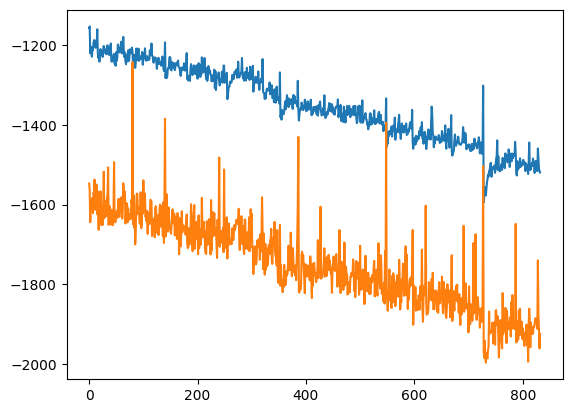

alpha 0.2 default_lr 0.0005


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [48]:
print(datetime.datetime.now())

2023-07-25 23:43:44.878430


In [ ]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# 評価関数計算

In [49]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [50]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.64152  validloss 1.09170±0.00000  bestvalidloss 1.09170  last_update 0
train: iter 1  trainloss 0.59262  validloss 0.83597±0.00000  bestvalidloss 0.83597  last_update 0
train: iter 2  trainloss 0.58508  validloss 0.84480±0.00000  bestvalidloss 0.83597  last_update 1
train: iter 3  trainloss 0.57373  validloss 0.83460±0.00000  bestvalidloss 0.83460  last_update 0
train: iter 4  trainloss 0.56569  validloss 0.83170±0.00000  bestvalidloss 0.83170  last_update 0
train: iter 5  trainloss 0.57094  validloss 0.80455±0.00000  bestvalidloss 0.80455  last_update 0
train: iter 6  trainloss 0.56724  validloss 0.79945±0.00000  bestvalidloss 0.79945  last_update 0
train: iter 7  trainloss 0.55962  validloss 0.81786±0.00000  bestvalidloss 0.79945  last_update 1
train: iter 8  trainloss 0.56317  validloss 0.83099±0.00000  bestvalidloss 0.79945  last_update 2
train: iter 9  trainloss 0.56749  validloss 0.87403±0.00000  bestvalidloss 0.79945  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.50578  validloss 0.82354±0.00000  bestvalidloss 0.79475  last_update 68
train: iter 84  trainloss 0.51424  validloss 0.81542±0.00000  bestvalidloss 0.79475  last_update 69
train: iter 85  trainloss 0.49980  validloss 0.81503±0.00000  bestvalidloss 0.79475  last_update 70
train: iter 86  trainloss 0.50638  validloss 0.82538±0.00000  bestvalidloss 0.79475  last_update 71
train: iter 87  trainloss 0.50564  validloss 0.81320±0.00000  bestvalidloss 0.79475  last_update 72
train: iter 88  trainloss 0.50385  validloss 0.82753±0.00000  bestvalidloss 0.79475  last_update 73
train: iter 89  trainloss 0.49722  validloss 0.81647±0.00000  bestvalidloss 0.79475  last_update 74
train: iter 90  trainloss 0.50992  validloss 0.82397±0.00000  bestvalidloss 0.79475  last_update 75
train: iter 91  trainloss 0.50113  validloss 0.81448±0.00000  bestvalidloss 0.79475  last_update 76
train: iter 92  trainloss 0.50009  validloss 0.83429±0.00000  bestvalidloss 0.79475  last_update 77


([0.6415160229429603,
  0.5926227895542979,
  0.5850849507376552,
  0.5737294364720583,
  0.5656925240531564,
  0.5709355751052498,
  0.5672413118183612,
  0.559616163559258,
  0.5631706198677421,
  0.5674918688833713,
  0.5487988345324993,
  0.5462302545085549,
  0.5425696343183517,
  0.5413589332252741,
  0.5368321934714914,
  0.551569807343185,
  0.5440529346466064,
  0.5381536012515425,
  0.5462486047297717,
  0.5361883277073503,
  0.5330428659915925,
  0.5308732142671942,
  0.5292289834469557,
  0.5322816915810108,
  0.5269849557429552,
  0.5338306274265051,
  0.530518620274961,
  0.5266796467825771,
  0.528947745077312,
  0.5251925125718117,
  0.5327415131032467,
  0.5262995455414057,
  0.52943214494735,
  0.5216955447569489,
  0.5227962182834744,
  0.5222842345014215,
  0.5271895833313465,
  0.5245937569066882,
  0.5173913458362221,
  0.5220807190984488,
  0.5241140453144908,
  0.5250430006533862,
  0.5235861796885729,
  0.5159090083092451,
  0.5252780633047223,
  0.521355925314

In [51]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.342336879932881
valid_loss:  -13.549179610061646
weight_alpha 1.0 h_min_tilde -12.324144 ell_tilde -6.983705425958633 kappa_tilde 0.00043272453822251614
train_loss:  -5.330438683128357
valid_loss:  -7.280485530090331
weight_alpha 0.2 h_min_tilde -12.324144 ell_tilde -5.720448052520751 kappa_tilde 0.0003891405188231706


In [52]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 46.82831  validloss 52.49209±0.00000  bestvalidloss 52.49209  last_update 0
train: iter 1  trainloss 37.78394  validloss 42.42266±0.00000  bestvalidloss 42.42266  last_update 0
train: iter 2  trainloss 30.53396  validloss 33.85075±0.00000  bestvalidloss 33.85075  last_update 0
train: iter 3  trainloss 25.07125  validloss 27.74194±0.00000  bestvalidloss 27.74194  last_update 0
train: iter 4  trainloss 20.63939  validloss 22.32797±0.00000  bestvalidloss 22.32797  last_update 0
train: iter 5  trainloss 16.97063  validloss 18.55579±0.00000  bestvalidloss 18.55579  last_update 0
train: iter 6  trainloss 13.78199  validloss 15.15985±0.00000  bestvalidloss 15.15985  last_update 0
train: iter 7  trainloss 11.54596  validloss 12.46422±0.00000  bestvalidloss 12.46422  last_update 0
train: iter 8  trainloss 9.55867  validloss 10.36630±0.00000  bestvalidloss 10.36630  last_update 0
train: iter 9  trainloss 8.02072  validloss 8.46526±0.00000  bestvalidloss 8.46526  last_upd

train: iter 83  trainloss -0.15555  validloss -0.45602±0.00000  bestvalidloss -0.50814  last_update 1
train: iter 84  trainloss -0.14925  validloss -0.41282±0.00000  bestvalidloss -0.50814  last_update 2
train: iter 85  trainloss -0.16133  validloss -0.47327±0.00000  bestvalidloss -0.50814  last_update 3
train: iter 86  trainloss -0.18559  validloss -0.48206±0.00000  bestvalidloss -0.50814  last_update 4
train: iter 87  trainloss -0.16484  validloss -0.47366±0.00000  bestvalidloss -0.50814  last_update 5
train: iter 88  trainloss -0.18233  validloss -0.45357±0.00000  bestvalidloss -0.50814  last_update 6
train: iter 89  trainloss -0.18857  validloss -0.44102±0.00000  bestvalidloss -0.50814  last_update 7
train: iter 90  trainloss -0.18493  validloss -0.44978±0.00000  bestvalidloss -0.50814  last_update 8
train: iter 91  trainloss -0.19051  validloss -0.52628±0.00000  bestvalidloss -0.52628  last_update 0
train: iter 92  trainloss -0.18013  validloss -0.45945±0.00000  bestvalidloss -0.5

train: iter 166  trainloss -0.20721  validloss -0.51236±0.00000  bestvalidloss -0.54139  last_update 57
train: iter 167  trainloss -0.21807  validloss -0.48562±0.00000  bestvalidloss -0.54139  last_update 58
train: iter 168  trainloss -0.18585  validloss -0.45592±0.00000  bestvalidloss -0.54139  last_update 59
train: iter 169  trainloss -0.23112  validloss -0.50001±0.00000  bestvalidloss -0.54139  last_update 60
train: iter 170  trainloss -0.19471  validloss -0.45856±0.00000  bestvalidloss -0.54139  last_update 61
train: iter 171  trainloss -0.21991  validloss -0.53498±0.00000  bestvalidloss -0.54139  last_update 62
train: iter 172  trainloss -0.25726  validloss -0.51474±0.00000  bestvalidloss -0.54139  last_update 63
train: iter 173  trainloss -0.18054  validloss -0.50526±0.00000  bestvalidloss -0.54139  last_update 64
train: iter 174  trainloss -0.16772  validloss -0.45006±0.00000  bestvalidloss -0.54139  last_update 65
train: iter 175  trainloss -0.20637  validloss -0.52076±0.00000 

train: iter 252  trainloss -0.20657  validloss -0.47730±0.00000  bestvalidloss -0.58886  last_update 56
train: iter 253  trainloss -0.20430  validloss -0.48747±0.00000  bestvalidloss -0.58886  last_update 57
train: iter 254  trainloss -0.19716  validloss -0.41560±0.00000  bestvalidloss -0.58886  last_update 58
train: iter 255  trainloss -0.22328  validloss -0.45602±0.00000  bestvalidloss -0.58886  last_update 59
train: iter 256  trainloss -0.16897  validloss -0.47894±0.00000  bestvalidloss -0.58886  last_update 60
train: iter 257  trainloss -0.17634  validloss -0.47047±0.00000  bestvalidloss -0.58886  last_update 61
train: iter 258  trainloss -0.22079  validloss -0.48174±0.00000  bestvalidloss -0.58886  last_update 62
train: iter 259  trainloss -0.21806  validloss -0.45081±0.00000  bestvalidloss -0.58886  last_update 63
train: iter 260  trainloss -0.21221  validloss -0.51317±0.00000  bestvalidloss -0.58886  last_update 64
train: iter 261  trainloss -0.18779  validloss -0.51407±0.00000 

train: iter 337  trainloss -0.21950  validloss -0.51772±0.00000  bestvalidloss -0.59996  last_update 68
train: iter 338  trainloss -0.18763  validloss -0.45535±0.00000  bestvalidloss -0.59996  last_update 69
train: iter 339  trainloss -0.21417  validloss -0.50646±0.00000  bestvalidloss -0.59996  last_update 70
train: iter 340  trainloss -0.20686  validloss -0.49819±0.00000  bestvalidloss -0.59996  last_update 71
train: iter 341  trainloss -0.18322  validloss -0.50902±0.00000  bestvalidloss -0.59996  last_update 72
train: iter 342  trainloss -0.21185  validloss -0.51457±0.00000  bestvalidloss -0.59996  last_update 73
train: iter 343  trainloss -0.21214  validloss -0.47031±0.00000  bestvalidloss -0.59996  last_update 74
train: iter 344  trainloss -0.16123  validloss -0.51457±0.00000  bestvalidloss -0.59996  last_update 75
train: iter 345  trainloss -0.17619  validloss -0.47659±0.00000  bestvalidloss -0.59996  last_update 76
train: iter 346  trainloss -0.23704  validloss -0.48681±0.00000 

In [53]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.3207, -0.0924, -4.4617, -1.6095], requires_grad=True)


In [54]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.19762  validloss 16.19393±0.00000  bestvalidloss 16.19393  last_update 0
train: iter 1  trainloss 2.67683  validloss 6.24256±0.00000  bestvalidloss 6.24256  last_update 0
train: iter 2  trainloss 2.68774  validloss 6.27129±0.00000  bestvalidloss 6.24256  last_update 1
train: iter 3  trainloss 2.57301  validloss 6.23161±0.00000  bestvalidloss 6.23161  last_update 0
train: iter 4  trainloss 2.61039  validloss 5.86247±0.00000  bestvalidloss 5.86247  last_update 0
train: iter 5  trainloss 2.52544  validloss 5.98453±0.00000  bestvalidloss 5.86247  last_update 1
train: iter 6  trainloss 2.61225  validloss 6.48673±0.00000  bestvalidloss 5.86247  last_update 2
train: iter 7  trainloss 2.51294  validloss 5.92225±0.00000  bestvalidloss 5.86247  last_update 3
train: iter 8  trainloss 2.55671  validloss 6.36261±0.00000  bestvalidloss 5.86247  last_update 4
train: iter 9  trainloss 2.51886  validloss 6.72690±0.00000  bestvalidloss 5.86247  last_update 5
train: iter 10  tr

train: iter 85  trainloss 2.38585  validloss 6.97454±0.00000  bestvalidloss 5.66329  last_update 71
train: iter 86  trainloss 2.41782  validloss 6.70970±0.00000  bestvalidloss 5.66329  last_update 72
train: iter 87  trainloss 2.43587  validloss 6.30064±0.00000  bestvalidloss 5.66329  last_update 73
train: iter 88  trainloss 2.48348  validloss 6.63398±0.00000  bestvalidloss 5.66329  last_update 74
train: iter 89  trainloss 2.40220  validloss 6.41684±0.00000  bestvalidloss 5.66329  last_update 75
train: iter 90  trainloss 2.39632  validloss 7.13177±0.00000  bestvalidloss 5.66329  last_update 76
train: iter 91  trainloss 2.36526  validloss 6.30736±0.00000  bestvalidloss 5.66329  last_update 77
train: iter 92  trainloss 2.46789  validloss 6.86737±0.00000  bestvalidloss 5.66329  last_update 78
train: iter 93  trainloss 2.42626  validloss 6.64025±0.00000  bestvalidloss 5.66329  last_update 79
train: iter 94  trainloss 2.37600  validloss 6.69825±0.00000  bestvalidloss 5.66329  last_update 80


In [55]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-7.4843)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(5.7786)


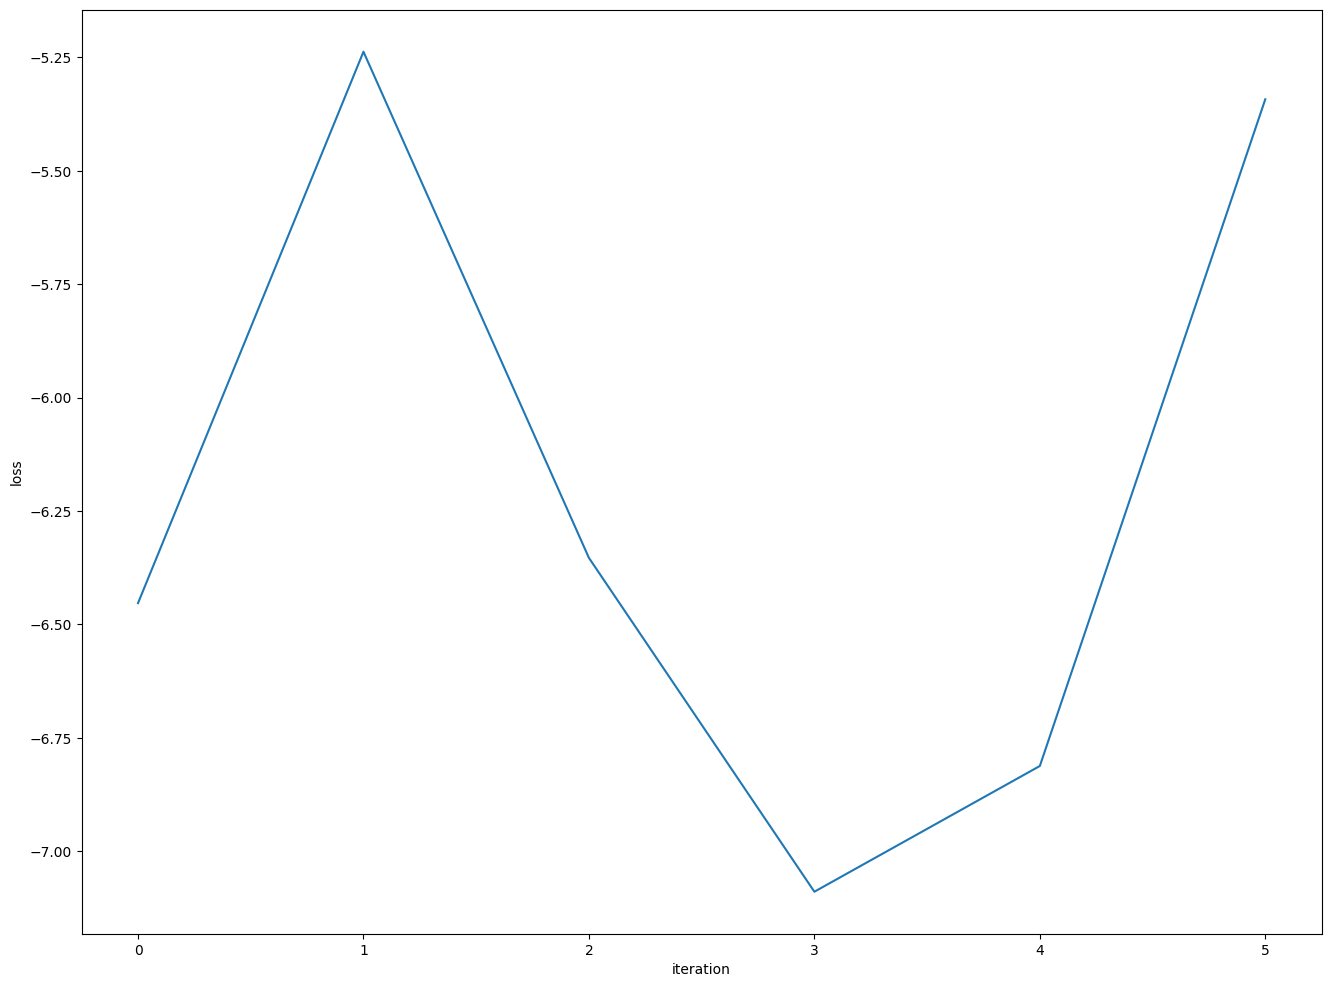

In [56]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

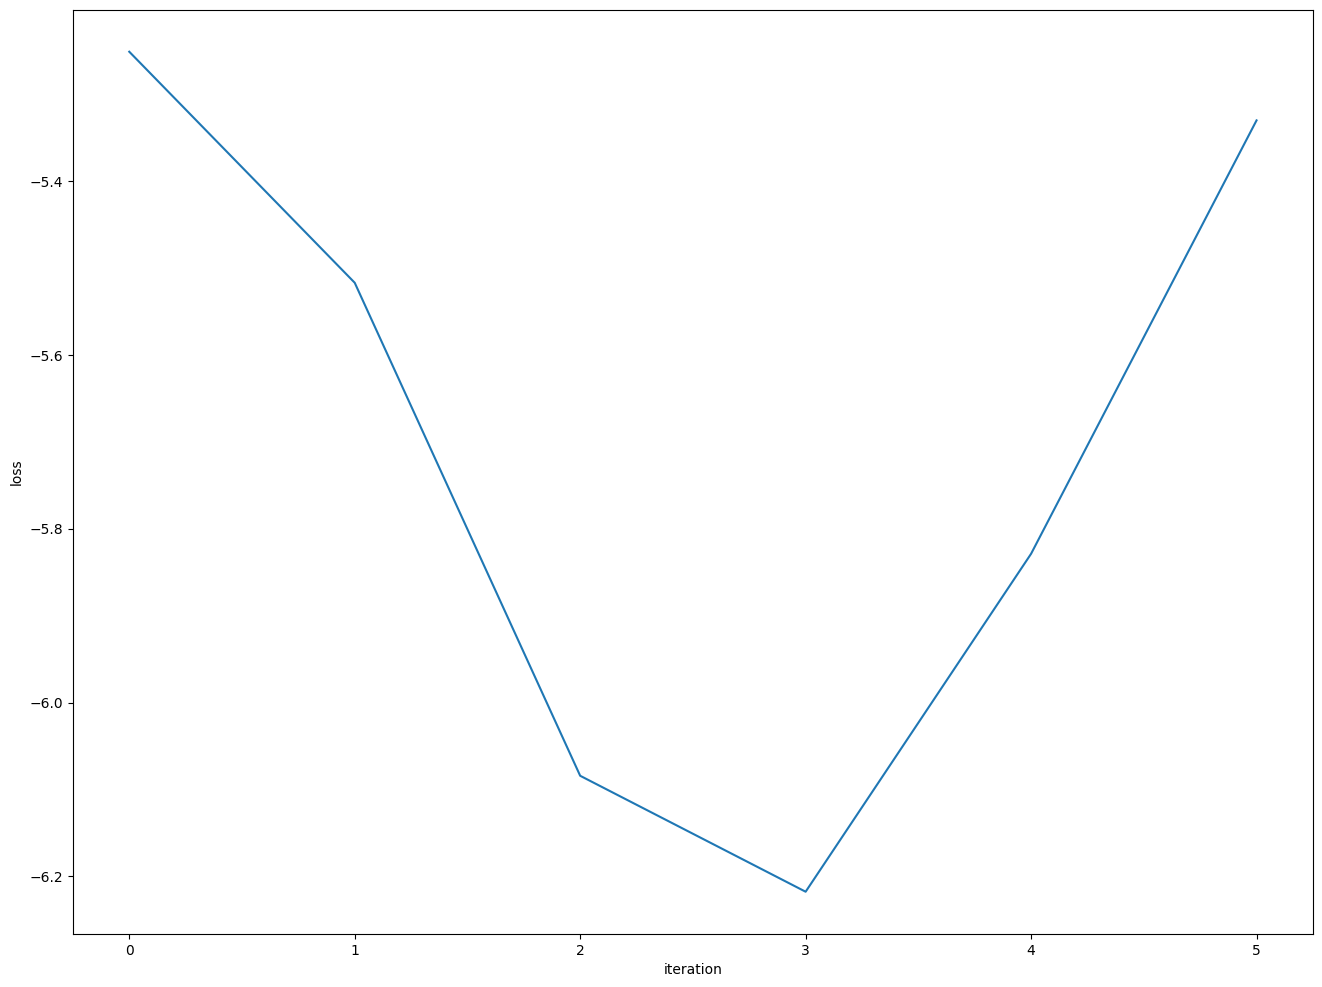

In [57]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")